<a href="https://colab.research.google.com/github/yukibefree/notebook/blob/master/signate_smbc_202506/2050615/signate_smbc_202506.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIGNATE SMBC Group GREEN×DATA　Challenge

## タスク内容
2018年のスペインの電力価格を予測  
24時間前の電力需給実績  
気象実績データ  
目的変数：timeに対するprice_actual

## その他補足
クロスバリデーションを使う際は時系列に沿って使うこと  
例）2015年のデータを使って2016年の予測は OK  
ランダムにクロスバリデーションを行うことは NG

日の出、日の入り情報は使用可能  

緯度経度は利用可能

## データ取得

In [ ]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ディレクトリパスの指定
dir_path = '/content/drive/MyDrive/Colab_Notebooks/signate_smbc_202506/'
# ファイルの確認
%ls $dir_path

 feature_description.csv               submission_lgbm.csv
 sample_submit.csv                     test.csv
 signate_smbc_202506.ipynb             train.csv
'signate_smbc_202506.ipynb のコピー'   tutorial.ipynb
 submission.csv


In [ ]:
# 日本語フォントを簡単に使う
!pip -q install japanize-matplotlib
import japanize_matplotlib

# 祝日取得
!pip install holidays
import holidays

# パッケージのアップグレード
!pip install --upgrade lightgbm

In [ ]:
# ライブラリのインポート
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from datetime import date
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

warnings.filterwarnings("ignore")

In [ ]:
# 指定されたディレクトリ内のCSVファイルを一括で読み込み
all_files = os.listdir(dir_path)
csv_files = [f for f in all_files if f.endswith('.csv')]

dfs = {}  # 各ファイルを格納するための辞書

# 読み込むファイル名を指定
filename = ['test', 'train']

for csv_file in csv_files:
    file_path = os.path.join(dir_path, csv_file)
    try:
        df_name = os.path.splitext(csv_file)[0]  # ファイル名をキーとして使用
        if df_name in filename:
          dfs[df_name] = pd.read_csv(file_path, index_col=0, header=0)
          print(f"{csv_file} を読み込みました。")
          display(dfs[df_name].head())
        else:
          print(f'{df_name}の読み込みはパスします')
          continue
    except Exception as e:
        print(f"{csv_file} の読み込み中にエラーが発生しました: {e}")

train.csv を読み込みました。


generation_biomass  \
time                                            
2015-01-02 00:00:00+01:00               447.0   
2015-01-02 01:00:00+01:00               449.0   
2015-01-02 02:00:00+01:00               448.0   
2015-01-02 03:00:00+01:00               438.0   
2015-01-02 04:00:00+01:00               428.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2015-01-02 00:00:00+01:00                                 329.0   
2015-01-02 01:00:00+01:00                                 328.0   
2015-01-02 02:00:00+01:00                                 323.0   
2015-01-02 03:00:00+01:00                                 254.0   
2015-01-02 04:00:00+01:00                                 187.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2015-01-02 00:00:00+01:00                 4844.0                       4821.0   
2015-01-02 01:00:00+01:00                 5196.0                       4755.0   
2015-01-02 02:00:00+01:00                 4857.0                       4581.0   
2015-01-02 03:00:00+01:00                 4314.0                       4131.0   
2015-01-02 04:00:00+01:00                 4130.0                       3840.0   

                           generation_fossil_oil  \
time                                               
2015-01-02 00:00:00+01:00                  162.0   
2015-01-02 01:00:00+01:00                  158.0   
2015-01-02 02:00:00+01:00                  157.0   
2015-01-02 03:00:00+01:00                  160.0   
2015-01-02 04:00:00+01:00                  156.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2015-01-02 00:00:00+01:00                                        863.0   
2015-01-02 01:00:00+01:00                                        920.0   
2015-01-02 02:00:00+01:00                                       1164.0   
2015-01-02 03:00:00+01:00                                       1503.0   
2015-01-02 04:00:00+01:00                                       1826.0   

                           generation_hydro_run_of_river_and_poundage  \
time                                                                    
2015-01-02 00:00:00+01:00                                      1051.0   
2015-01-02 01:00:00+01:00                                      1009.0   
2015-01-02 02:00:00+01:00                                       973.0   
2015-01-02 03:00:00+01:00                                       949.0   
2015-01-02 04:00:00+01:00                                       953.0   

                           generation_hydro_water_reservoir  \
time                                                          
2015-01-02 00:00:00+01:00                            1899.0   
2015-01-02 01:00:00+01:00                            1658.0   
2015-01-02 02:00:00+01:00                            1371.0   
2015-01-02 03:00:00+01:00                             779.0   
2015-01-02 04:00:00+01:00                             720.0   

                           generation_nuclear  generation_other  ...  \
time                                                             ...   
2015-01-02 00:00:00+01:00              7096.0              43.0  ...   
2015-01-02 01:00:00+01:00              7096.0              43.0  ...   
2015-01-02 02:00:00+01:00              7099.0              43.0  ...   
2015-01-02 03:00:00+01:00              7098.0              43.0  ...   
2015-01-02 04:00:00+01:00              7097.0              43.0  ...   

                           seville_wind_deg  seville_rain_1h  seville_rain_3h  \
time                                                                            
2015-01-02 00:00:00+01:00                33              0.0              0.0   
2015-01-02 01:00:00+01:00                33              0.

test.csv を読み込みました。


generation_biomass  \
time                                            
2018-01-01 00:00:00+01:00               279.0   
2018-01-01 01:00:00+01:00               282.0   
2018-01-01 02:00:00+01:00               283.0   
2018-01-01 03:00:00+01:00               280.0   
2018-01-01 04:00:00+01:00               286.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2018-01-01 00:00:00+01:00                                   0.0   
2018-01-01 01:00:00+01:00                                   0.0   
2018-01-01 02:00:00+01:00                                   0.0   
2018-01-01 03:00:00+01:00                                   0.0   
2018-01-01 04:00:00+01:00                                   0.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2018-01-01 00:00:00+01:00                 3927.0                        895.0   
2018-01-01 01:00:00+01:00                 3948.0                        878.0   
2018-01-01 02:00:00+01:00                 3791.0                        890.0   
2018-01-01 03:00:00+01:00                 3671.0                        881.0   
2018-01-01 04:00:00+01:00                 3460.0                        861.0   

                           generation_fossil_oil  \
time                                               
2018-01-01 00:00:00+01:00                  189.0   
2018-01-01 01:00:00+01:00                  177.0   
2018-01-01 02:00:00+01:00                  175.0   
2018-01-01 03:00:00+01:00                  175.0   
2018-01-01 04:00:00+01:00                  173.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2018-01-01 00:00:00+01:00                                        230.0   
2018-01-01 01:00:00+01:00                                       1269.0   
2018-01-01 02:00:00+01:00                                       2197.0   
2018-01-01 03:00:00+01:00                                       2965.0   
2018-01-01 04:00:00+01:00                                       2705.0   

                           generation_hydro_run_of_river_and_poundage  \
time                                                                    
2018-01-01 00:00:00+01:00                                      1069.0   
2018-01-01 01:00:00+01:00                                      1058.0   
2018-01-01 02:00:00+01:00                                      1052.0   
2018-01-01 03:00:00+01:00                                      1032.0   
2018-01-01 04:00:00+01:00                                      1001.0   

                           generation_hydro_water_reservoir  \
time                                                          
2018-01-01 00:00:00+01:00                            1893.0   
2018-01-01 01:00:00+01:00                            1024.0   
2018-01-01 02:00:00+01:00                             888.0   
2018-01-01 03:00:00+01:00                             645.0   
2018-01-01 04:00:00+01:00                             661.0   

                           generation_nuclear  generation_other  ...  \
time                                                             ...   
2018-01-01 00:00:00+01:00              7104.0              53.0  ...   
2018-01-01 01:00:00+01:00              7101.0              52.0  ...   
2018-01-01 02:00:00+01:00              7100.0              52.0  ...   
2018-01-01 03:00:00+01:00              7101.0              53.0  ...   
2018-01-01 04:00:00+01:00              7101.0              53.0  ...   

                           seville_wind_speed  seville_wind_deg  \
time                                                              
2018-01-01 00:00:00+01:00                   1               343   
2018-01-01 01:00:00+01:00                   1               343   
2018-01-01 02:00:00+01:00         

sample_submitの読み込みはパスします
feature_descriptionの読み込みはパスします
submission_lgbmの読み込みはパスします
submissionの読み込みはパスします


In [ ]:
# 各データフレームのカラム情報を取得

for df_name, df in dfs.items():
    print(f"\nDataFrame: {df_name}")
    df.info()
    display(df.describe())
    print("-" * 50)


DataFrame: train
<class 'pandas.core.frame.DataFrame'>
Index: 26280 entries, 2015-01-02 00:00:00+01:00 to 2017-12-31 23:00:00+01:00
Data columns (total 91 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           26259 non-null  float64
 1   generation_fossil_brown_coal/lignite         26260 non-null  float64
 2   generation_fossil_gas                        26260 non-null  float64
 3   generation_fossil_hard_coal                  26260 non-null  float64
 4   generation_fossil_oil                        26259 non-null  float64
 5   generation_hydro_pumped_storage_consumption  26259 non-null  float64
 6   generation_hydro_run_of_river_and_poundage   26259 non-null  float64
 7   generation_hydro_water_reservoir             26260 non-null  float64
 8   generation_nuclear                           26261 non-null  float64
 9   generation_othe

generation_biomass  generation_fossil_brown_coal/lignite  \
count        26259.000000                          26260.000000   
mean           399.151719                            480.261729   
std             89.897230                            365.334152   
min              0.000000                              0.000000   
25%            341.000000                              0.000000   
50%            378.000000                            564.000000   
75%            480.000000                            863.000000   
max            592.000000                            999.000000   

       generation_fossil_gas  generation_fossil_hard_coal  \
count           26260.000000                 26260.000000   
mean             5559.830122                  4447.482216   
std              2272.017312                  2027.884207   
min              1518.000000                     0.000000   
25%              4071.000000                  2624.000000   
50%              4866.000000                  4764.000000   
75%              6264.000000                  6107.000000   
max             20034.000000                  8359.000000   

       generation_fossil_oil  generation_hydro_pumped_storage_consumption  \
count           26259.000000                                 26259.000000   
mean              303.806009                                   504.322899   
std                54.036443                                   804.870327   
min                 0.000000                                     0.000000   
25%               268.000000                                     0.000000   
50%               303.000000                                    90.000000   
75%               336.000000                                   696.000000   
max               449.000000                                  4523.000000   

       generation_hydro_run_of_river_and_poundage  \
count                                26259.000000   
mean                                   888.150844   
std                                    369.509637   
min                                      0.000000   
25%                                    595.000000   
50%                                    795.000000   
75%                                   1148.000000   
max                                   1939.000000   

       generation_hydro_water_reservoir  generation_nuclear  generation_other  \
count                      26260.000000        26261.000000      26260.000000   
mean                        2507.795316         6323.681200         62.500685   
std                         1869.150134          827.939857         21.451727   
min                            0.000000            0.000000          0.000000   
25%                          955.000000         5900.000000         53.000000   
50%                         1991.000000         6734.000000         58.000000   
75%                         3666.000000         7071.000000         84.000000   
max                         9389.000000         7116.000000        106.000000   

       ...  seville_pressure  seville_humidity  seville_wind_speed  \
count  ...      26280.000000       26280.00000        26280.000000   
mean   ...       1019.224543          62.65898            2.424353   
std    ...          6.846954          23.31406            1.839498   
min    ...        993.000000           7.00000            0.000000   
25%    ...       1014.000000          44.00000            1.000000   
50%    ...       1018.000000          66.00000            2.000000   
75%    ...       1024.000000          82.00000            3.000000   
max    ...       1090.000000         100.00000           15.000000   

       seville_wind_deg  seville_rain_1h  seville_rain_3h  seville_snow_3h  \
count      26280.000000     26280.000000     26280.000000          26280.0   
mean         149.538661         0.039498         0.000243              0.0   
std          104.268808         0.204880         0.003961              0.0   
min     

--------------------------------------------------

DataFrame: test
<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2018-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 90 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           8758 non-null   float64
 1   generation_fossil_brown_coal/lignite         8758 non-null   float64
 2   generation_fossil_gas                        8758 non-null   float64
 3   generation_fossil_hard_coal                  8758 non-null   float64
 4   generation_fossil_oil                        8758 non-null   float64
 5   generation_hydro_pumped_storage_consumption  8758 non-null   float64
 6   generation_hydro_run_of_river_and_poundage   8758 non-null   float64
 7   generation_hydro_water_reservoir             8758 non-null   float64
 8   generation_nuclear                      

generation_biomass  generation_fossil_brown_coal/lignite  \
count         8758.000000                           8758.000000   
mean           336.875771                            352.930121   
std             44.562788                            300.150290   
min              0.000000                              0.000000   
25%            309.000000                              0.000000   
50%            348.000000                            414.000000   
75%            371.000000                            635.750000   
max            413.000000                            959.000000   

       generation_fossil_gas  generation_fossil_hard_coal  \
count            8758.000000                  8758.000000   
mean             5810.462206                  3689.136675   
std              1967.569086                  1618.806576   
min                 0.000000                   700.000000   
25%              4325.000000                  2284.250000   
50%              5287.000000                  3815.000000   
75%              6812.500000                  5090.750000   
max             13292.000000                  6928.000000   

       generation_fossil_oil  generation_hydro_pumped_storage_consumption  \
count            8758.000000                                  8758.000000   
mean              282.176639                                   388.825074   
std                43.622782                                   746.575384   
min                44.000000                                     0.000000   
25%               248.000000                                     0.000000   
50%               291.000000                                    17.000000   
75%               317.000000                                   386.000000   
max               364.000000                                  4218.000000   

       generation_hydro_run_of_river_and_poundage  \
count                                 8758.000000   
mean                                  1223.473624   
std                                    385.951826   
min                                    467.000000   
25%                                    918.000000   
50%                                   1203.000000   
75%                                   1566.000000   
max                                   2000.000000   

       generation_hydro_water_reservoir  generation_nuclear  generation_other  \
count                       8758.000000         8758.000000       8758.000000   
mean                        2898.403859         6085.006394         53.418703   
std                         1698.149263          850.307688         14.041959   
min                          310.000000          998.000000          0.000000   
25%                         1519.250000         5062.000000         53.000000   
50%                         2609.000000         6071.000000         57.000000   
75%                         3956.000000         6979.000000         59.000000   
max                         9728.000000         7117.000000         83.000000   

       ...  seville_temp_max  seville_pressure  seville_humidity  \
count  ...       8760.000000       8760.000000       8760.000000   
mean   ...        291.589474       1016.417237         67.122831   
std    ...          7.591655          6.404969         21.208030   
min    ...        272.150000        986.000000         11.000000   
25%    ...        286.150000       1013.000000         51.000000   
50%    ...        290.150000       1016.000000         71.000000   
75%    ...        296.150000       1020.000000         87.000000   
max    ...        316.150000       1037.000000        100.000000   

       seville_wind_speed  seville_wind_deg  seville_rain_1h  seville_rain_3h  \
count         8760.000000       8760.000000      8760.000000      8760.000000   
mean             2.656849        159.225913         0.046164         0.000001   
std              1.944383        104.161822         0.244303         0.000128   
min           

--------------------------------------------------


## 探索的データ分析（EDA）

In [ ]:
# 目的変数の設定
df_target_name = None
target_var = 'price_actual'

# 目的変数が含まれているカラムを取得
for name, df in dfs.items():
  if target_var in df.columns:
    df_target_name = name
    break

if df_target_name:
  # 元のデータフレームを保持する
  df_target = deepcopy(dfs[df_target_name])
  print(f"\n目的変数 'price_actual' を含むデータフレーム: {df_target_name}")
else:
    print("目的変数 'price_actual' を含むデータフレームが見つかりませんでした。データフレームの構造を確認してください。")


目的変数 'price_actual' を含むデータフレーム: train


In [ ]:
from logging import exception
# 'test' データフレームを取得
if 'test' not in dfs:
    raise exception('テストデータフレームが見つかりません。処理をスキップします。')
else:
    df_test = deepcopy(dfs['test']) # 元のデータフレームを保持するためコピー

In [ ]:
# ユニーク値の確認
print("ユニーク値の確認")
print('学習データ')
print(df_target.select_dtypes(include='object').nunique().sort_values(ascending=False))
print("-" * 50)
print('テストデータ')
print(df_test.select_dtypes(include='object').nunique().sort_values(ascending=False))
print("-" * 50)

ユニーク値の確認
学習データ
bilbao_weather_description       32
barcelona_weather_description    29
seville_weather_description      29
bilbao_weather_icon              24
madrid_weather_description       24
barcelona_weather_icon           24
valencia_weather_description     23
madrid_weather_icon              22
seville_weather_icon             21
valencia_weather_icon            21
seville_weather_main             10
madrid_weather_main               9
bilbao_weather_main               9
barcelona_weather_main            9
valencia_weather_main             8
dtype: int64
--------------------------------------------------
テストデータ
madrid_weather_description       30
bilbao_weather_description       28
seville_weather_description      26
barcelona_weather_description    24
bilbao_weather_icon              23
madrid_weather_icon              23
barcelona_weather_icon           23
valencia_weather_icon            21
seville_weather_icon             21
valencia_weather_description     20
madrid_weather

In [ ]:
# データタイプの確認
print("データタイプの確認")
unique_columns = df_target.select_dtypes(include='object').columns.tolist()
for col in unique_columns:
  print(f"カラム名：{col} {df_target[col].nunique()}つ\n", df_target[col].unique())
print("-" * 50)

データタイプの確認
カラム名：valencia_weather_main 8つ
 ['clear' 'clouds' 'rain' 'mist' 'thunderstorm' 'drizzle' 'fog' 'smoke']
カラム名：valencia_weather_description 23つ
 ['sky is clear' 'few clouds' 'scattered clouds' 'broken clouds'
 'overcast clouds' 'light rain' 'moderate rain' 'heavy intensity rain'
 'mist' 'heavy intensity shower rain' 'shower rain' 'very heavy rain'
 'thunderstorm with heavy rain' 'thunderstorm with light rain'
 'proximity thunderstorm' 'thunderstorm' 'light intensity shower rain'
 'light intensity drizzle' 'thunderstorm with rain' 'fog' 'smoke'
 'drizzle' 'heavy intensity drizzle']
カラム名：valencia_weather_icon 21つ
 ['01n' '01d' '01' '02n' '02d' '02' '03' '04n' '04' '10n' '03n' '10' '04d'
 '03d' '10d' '50d' '09n' '11d' '11n' '09d' '50n']
カラム名：madrid_weather_main 9つ
 ['clear' 'clouds' 'rain' 'fog' 'thunderstorm' 'drizzle' 'mist' 'haze'
 'snow']
カラム名：madrid_weather_description 24つ
 ['sky is clear' 'few clouds' 'scattered clouds' 'broken clouds'
 'overcast clouds' 'light rain' 'moderat

In [ ]:
# インデックスの確認
print(df_target.index.dtype)
print(df_target.index)
print(df_test.index.dtype)
print(df_test.index)

object
Index(['2015-01-02 00:00:00+01:00', '2015-01-02 01:00:00+01:00',
       '2015-01-02 02:00:00+01:00', '2015-01-02 03:00:00+01:00',
       '2015-01-02 04:00:00+01:00', '2015-01-02 05:00:00+01:00',
       '2015-01-02 06:00:00+01:00', '2015-01-02 07:00:00+01:00',
       '2015-01-02 08:00:00+01:00', '2015-01-02 09:00:00+01:00',
       ...
       '2017-12-31 14:00:00+01:00', '2017-12-31 15:00:00+01:00',
       '2017-12-31 16:00:00+01:00', '2017-12-31 17:00:00+01:00',
       '2017-12-31 18:00:00+01:00', '2017-12-31 19:00:00+01:00',
       '2017-12-31 20:00:00+01:00', '2017-12-31 21:00:00+01:00',
       '2017-12-31 22:00:00+01:00', '2017-12-31 23:00:00+01:00'],
      dtype='object', name='time', length=26280)
object
Index(['2018-01-01 00:00:00+01:00', '2018-01-01 01:00:00+01:00',
       '2018-01-01 02:00:00+01:00', '2018-01-01 03:00:00+01:00',
       '2018-01-01 04:00:00+01:00', '2018-01-01 05:00:00+01:00',
       '2018-01-01 06:00:00+01:00', '2018-01-01 07:00:00+01:00',
       '2018-01

In [ ]:
from sklearn.preprocessing import LabelEncoder

# オブジェクト型のカラム名を取得
object_cols_train = df_target.select_dtypes(include='object').columns.tolist()
object_cols_test = df_test.select_dtypes(include='object').columns.tolist()

print('学習データのエンコード適用対象：', object_cols_train)
print('テストデータのエンコード適用対象：', object_cols_test)

# Label Encodingを適用
for col in object_cols_train:
    le = LabelEncoder()
    df_target[col] = le.fit_transform(df_target[col])

for col in object_cols_test:
    le = LabelEncoder()
    # 訓練データに存在しないカテゴリがテストデータにある場合を考慮
    # ここでは単純に fit_transform していますが、実運用では注意が必要です
    # 例: 訓練データでfitし、テストデータでtransformするなどの工夫が必要
    df_test[col] = le.fit_transform(df_test[col])

print("オブジェクト型のカラムに対してLabel Encodingを適用しました。")
df_target.info()
df_test.info()

学習データのエンコード適用対象： ['valencia_weather_main', 'valencia_weather_description', 'valencia_weather_icon', 'madrid_weather_main', 'madrid_weather_description', 'madrid_weather_icon', 'bilbao_weather_main', 'bilbao_weather_description', 'bilbao_weather_icon', 'barcelona_weather_main', 'barcelona_weather_description', 'barcelona_weather_icon', 'seville_weather_main', 'seville_weather_description', 'seville_weather_icon']
テストデータのエンコード適用対象： ['valencia_weather_main', 'valencia_weather_description', 'valencia_weather_icon', 'madrid_weather_main', 'madrid_weather_description', 'madrid_weather_icon', 'bilbao_weather_main', 'bilbao_weather_description', 'bilbao_weather_icon', 'barcelona_weather_main', 'barcelona_weather_description', 'barcelona_weather_icon', 'seville_weather_main', 'seville_weather_description', 'seville_weather_icon']
オブジェクト型のカラムに対してLabel Encodingを適用しました。
<class 'pandas.core.frame.DataFrame'>
Index: 26280 entries, 2015-01-02 00:00:00+01:00 to 2017-12-31 23:00:00+01:00
Data columns (

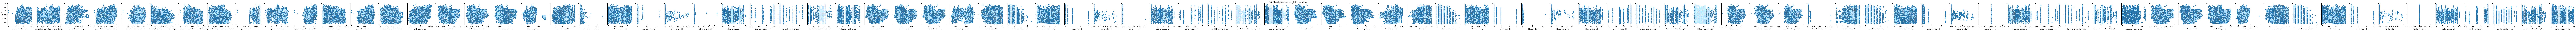

In [ ]:
# 目的変数を設定してペアプロット
target = 'price_actual'
pair_plot = False
if pair_plot:
  sns.pairplot(df_target, y_vars=[target], x_vars=[col for col in df_target.columns if col != 'price_actual'])
  plt.suptitle('Pair Plot of price actual vs Other Variables', y=1.02)
  plt.show()

In [ ]:
# 目的変数 'price_actual' の基本統計量
print("\n目的変数 'price_actual' の基本統計量:")
display(df_target[target_var].describe())

# 目的変数 'price_actual' のヒストグラム
plt.figure(figsize=(10, 6))
sns.histplot(df_target[target_var], kde=True)
plt.title('price_actualの分布')
plt.xlabel(target_var)
plt.ylabel('度数')
plt.grid(True)
plt.show()

# 時系による散布図
plt.figure(figsize=(14, 7))
df_target[target_var].plot()
plt.title('price_actualの時系列変化')
plt.xlabel('時間')
plt.ylabel(target_var)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


# Box plot for 'price_actual'
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_target[target_var])
plt.title('price_actualの箱ひげ図')
plt.ylabel(target_var)
plt.grid(True)
plt.show()

print("-" * 50)


目的変数 'price_actual' の基本統計量:


count    26280.000000
mean        56.028338
std         14.340356
min          9.330000
25%         47.617500
50%         55.930000
75%         65.192500
max        116.800000
Name: price_actual, dtype: float64

--------------------------------------------------


## 前処理

In [ ]:
# 時系列データの変換
def convert_to_datetime(df, only_index=True, column_name='time', utc=False, tz='Asia/Tokyo'):
  try:
    if column_name in df.columns and not only_index:
      df[column_name] = pd.to_datetime(df[column_name], utc=utc)
      print('データ型：',df[column_name].dtype)
      print(f'{column_name} 列をdatetimeに変換しました')
    else:
      df.index = pd.to_datetime(df.index, utc=utc).tz_convert(tz)
      print('データ型：',df.index.dtype)
      print('インデックスをdatetimeに変換しました')
  except Exception as e:
    print(f"datetime変換に失敗しました: {e}")

In [ ]:
# 時系列データの変換
convert_to_datetime(df_target, utc=True, tz='Europe/Berlin')

print("\n--- テストデータ前処理 ---")

# datetime型に変換
convert_to_datetime(df_test, utc=True, tz='Europe/Berlin')
print("加工後のデータフレームサイズ：", df_test.shape)

データ型： datetime64[ns, Europe/Berlin]
インデックスをdatetimeに変換しました

--- テストデータ前処理 ---
データ型： datetime64[ns, Europe/Berlin]
インデックスをdatetimeに変換しました
加工後のデータフレームサイズ： (8760, 90)


In [ ]:
# 年、月、日、時間列を追加
df_target['year'] = df_target.index.year
df_target['month'] = df_target.index.month
df_target['day'] = df_target.index.day
df_target['hour'] =df_target.index.hour

# 曜日情報を追加 (月曜日=0, 日曜日=6)
df_target['dayofweek'] = df_target.index.dayofweek

# 結果の確認
display(df_target.head())

generation_biomass  \
time                                            
2015-01-02 00:00:00+01:00               447.0   
2015-01-02 01:00:00+01:00               449.0   
2015-01-02 02:00:00+01:00               448.0   
2015-01-02 03:00:00+01:00               438.0   
2015-01-02 04:00:00+01:00               428.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2015-01-02 00:00:00+01:00                                 329.0   
2015-01-02 01:00:00+01:00                                 328.0   
2015-01-02 02:00:00+01:00                                 323.0   
2015-01-02 03:00:00+01:00                                 254.0   
2015-01-02 04:00:00+01:00                                 187.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2015-01-02 00:00:00+01:00                 4844.0                       4821.0   
2015-01-02 01:00:00+01:00                 5196.0                       4755.0   
2015-01-02 02:00:00+01:00                 4857.0                       4581.0   
2015-01-02 03:00:00+01:00                 4314.0                       4131.0   
2015-01-02 04:00:00+01:00                 4130.0                       3840.0   

                           generation_fossil_oil  \
time                                               
2015-01-02 00:00:00+01:00                  162.0   
2015-01-02 01:00:00+01:00                  158.0   
2015-01-02 02:00:00+01:00                  157.0   
2015-01-02 03:00:00+01:00                  160.0   
2015-01-02 04:00:00+01:00                  156.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2015-01-02 00:00:00+01:00                                        863.0   
2015-01-02 01:00:00+01:00                                        920.0   
2015-01-02 02:00:00+01:00                                       1164.0   
2015-01-02 03:00:00+01:00                                       1503.0   
2015-01-02 04:00:00+01:00                                       1826.0   

                           generation_hydro_run_of_river_and_poundage  \
time                                                                    
2015-01-02 00:00:00+01:00                                      1051.0   
2015-01-02 01:00:00+01:00                                      1009.0   
2015-01-02 02:00:00+01:00                                       973.0   
2015-01-02 03:00:00+01:00                                       949.0   
2015-01-02 04:00:00+01:00                                       953.0   

                           generation_hydro_water_reservoir  \
time                                                          
2015-01-02 00:00:00+01:00                            1899.0   
2015-01-02 01:00:00+01:00                            1658.0   
2015-01-02 02:00:00+01:00                            1371.0   
2015-01-02 03:00:00+01:00                             779.0   
2015-01-02 04:00:00+01:00                             720.0   

                           generation_nuclear  generation_other  ...  \
time                                                             ...   
2015-01-02 00:00:00+01:00              7096.0              43.0  ...   
2015-01-02 01:00:00+01:00              7096.0              43.0  ...   
2015-01-02 02:00:00+01:00              7099.0              43.0  ...   
2015-01-02 03:00:00+01:00              7098.0              43.0  ...   
2015-01-02 04:00:00+01:00              7097.0              43.0  ...   

                           seville_weather_id  seville_weather_main  \
time                                                                  
2015-01-02 00:00:00+01:00                 800                     0   
2015-01-02 01:00:00+01:00                 800                     0   
2015-01-02 02:00:0

In [ ]:
# Spainは ES がコードである
spain_holidays = holidays.country_holidays('ES')
date(2025, 1, 2) in spain_holidays

False

In [ ]:
import holidays
from datetime import date, timedelta

class HolidayChecker:
    def __init__(self, country='ES', city_list=None):
        self.country = country
        self.city_list = city_list if city_list else []
        self.country_holidays = holidays.country_holidays(country)

    def is_holiday_or_weekend(self, dt: date) -> int:
        """
        指定された日付が祝日または土日かを判定する。
        """
        return int(dt in self.country_holidays or dt.weekday() >= 5)

    def is_holiday_or_weekend_by_city(self, dt: date, city: str) -> int:
        """
        指定された日付が都市における祝日または土日かを判定する。
        """
        return int(dt in holidays.country_holidays(self.country, subdiv=city) or dt.weekday() >= 5)

    def check_next_day(self, dt: date) -> int:
        """
        指定された日付の翌日が祝日または土日かを判定する。
        """
        next_day = dt + timedelta(days=1)
        return int(self.is_holiday_or_weekend(next_day))

    def check_current_day(self, dt: date) -> int:
        """
        指定された日付が祝日または土日かを判定する。
        (is_holiday_or_weekend と同じ機能だが、要求に応じて分割)
        """
        return int(self.is_holiday_or_weekend(dt))

    def check_previous_day(self, dt: date) -> int:
        """
        指定された日付の前日が祝日または土日かを判定する。
        """
        previous_day = dt - timedelta(days=1)
        return int(self.is_holiday_or_weekend(previous_day))

    def consecutive_holiday_or_weekend(self, dt: date) -> int:
        """
        指定された日付を含む連続した祝日または土日の日数を計算する。
        指定された日付が祝日または土日でない場合は0を返す。
        """
        if not self.is_holiday_or_weekend(dt):
            return 0

        count = 0
        current_date = dt
        # 前方向の連続日数をカウント
        while self.is_holiday_or_weekend(current_date):
            count += 1
            current_date -= timedelta(days=1)

        return count

In [ ]:
# HolidayCheckerクラスのインスタンスを作成
checker = HolidayChecker('ES')

# df_targetに対して各フラグを作成
# 'is_holiday_or_weekend_flag': 当日が祝日または週末かどうか
df_target['is_holiday_or_weekend_flag'] = df_target.index.map(
    lambda x: checker.is_holiday_or_weekend(x.date())
)

# 'is_next_day_holiday_or_weekend_flag': 翌日が祝日または週末かどうか
df_target['is_next_day_holiday_or_weekend_flag'] = df_target.index.map(
    lambda x: checker.check_next_day(x.date())
)

# 'is_previous_day_holiday_or_weekend_flag': 前日が祝日または週末かどうか
df_target['is_previous_day_holiday_or_weekend_flag'] = df_target.index.map(
    lambda x: checker.check_previous_day(x.date())
)

# 'consecutive_holiday_or_weekend'：連続で何日の祝日または週末かどうか
df_target['consecutive_holiday_or_weekend'] = df_target.index.map(
    lambda x: checker.consecutive_holiday_or_weekend(x.date())
)


add_column = ['is_holiday_or_weekend_flag', 'is_next_day_holiday_or_weekend_flag', 'is_previous_day_holiday_or_weekend_flag','consecutive_holiday_or_weekend']

# 結果の確認
display(df_target[add_column].head())

is_holiday_or_weekend_flag  \
time                                                    
2015-01-02 00:00:00+01:00                           0   
2015-01-02 01:00:00+01:00                           0   
2015-01-02 02:00:00+01:00                           0   
2015-01-02 03:00:00+01:00                           0   
2015-01-02 04:00:00+01:00                           0   

                           is_next_day_holiday_or_weekend_flag  \
time                                                             
2015-01-02 00:00:00+01:00                                    1   
2015-01-02 01:00:00+01:00                                    1   
2015-01-02 02:00:00+01:00                                    1   
2015-01-02 03:00:00+01:00                                    1   
2015-01-02 04:00:00+01:00                                    1   

                           is_previous_day_holiday_or_weekend_flag  \
time                                                                 
2015-01-02 00:00:00+01:00                                        1   
2015-01-02 01:00:00+01:00                                        1   
2015-01-02 02:00:00+01:00                                        1   
2015-01-02 03:00:00+01:00                                        1   
2015-01-02 04:00:00+01:00                                        1   

                           consecutive_holiday_or_weekend  
time                                                       
2015-01-02 00:00:00+01:00                               0  
2015-01-02 01:00:00+01:00                               0  
2015-01-02 02:00:00+01:00                               0  
2015-01-02 03:00:00+01:00                               0  
2015-01-02 04:00:00+01:00                               0

In [ ]:
# 都市ごとの祝日を取得
city_code = ['VC', 'MD']

In [ ]:
def plot_time_by_column(df, target_columns, group_column='year'):
  # 時間帯ごとの平均電力価格を計算
  time_price = df_target.groupby(group_column)[target_columns].mean()

  # 結果の表示
  print("時間帯別 平均電力価格:")
  #display(time_price)

  # グラフで表示
  plt.figure(figsize=(12, 6))
  time_price.plot(kind='bar')
  plt.title(f'{group_column} 別 平均電力価格')
  plt.xlabel(group_column)
  plt.ylabel('平均電力価格 (price_actual)')
  plt.xticks(rotation=0)
  plt.grid(axis='y')
  plt.show()

時間帯別 平均電力価格:


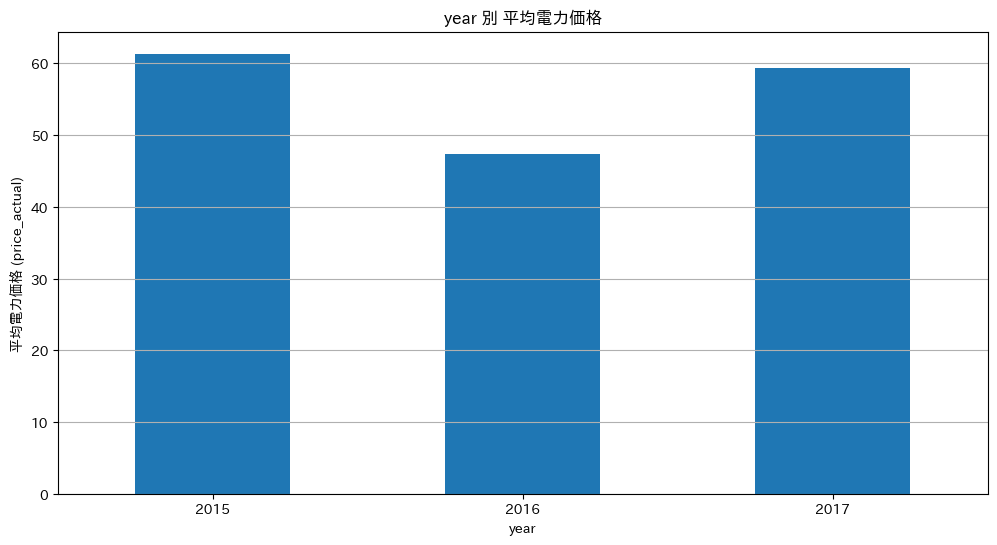

時間帯別 平均電力価格:


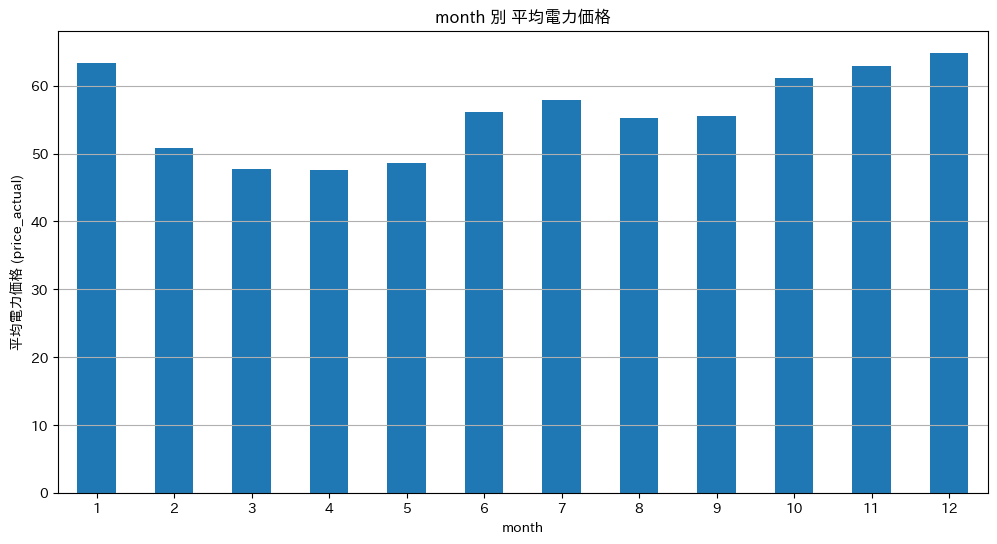

時間帯別 平均電力価格:


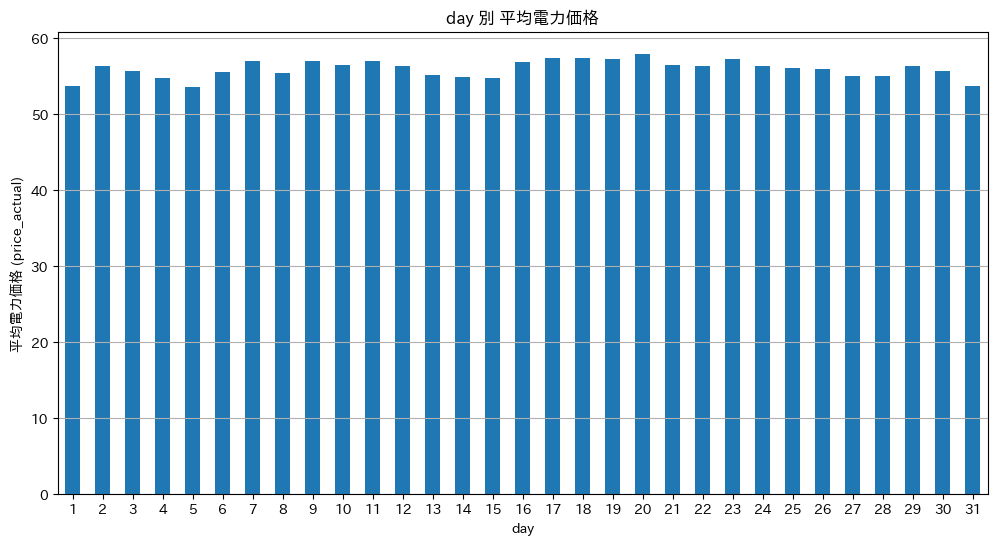

時間帯別 平均電力価格:


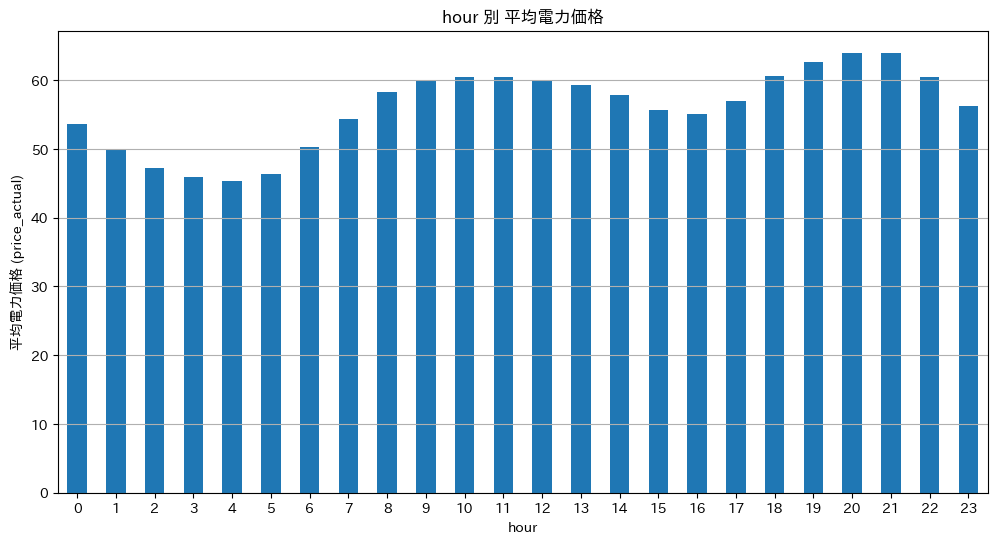

時間帯別 平均電力価格:


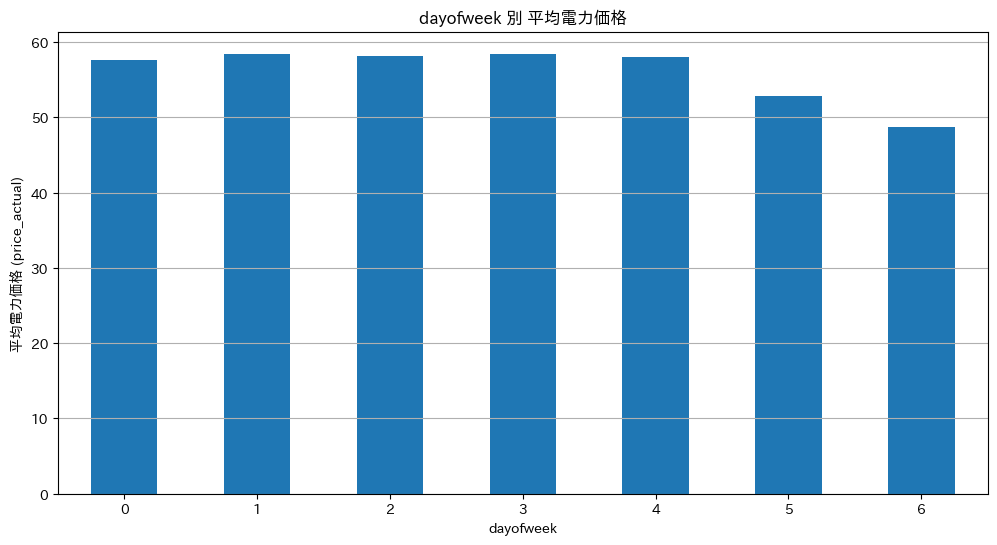

In [ ]:
# 時系列カラム
time_columns = ['year', 'month', 'day', 'hour', 'dayofweek']

# 各時間属性毎の傾向を見る
for col in time_columns:
  plot_time_by_column(df_target, target_columns=target_var, group_column=col)

時間帯別 平均電力価格:


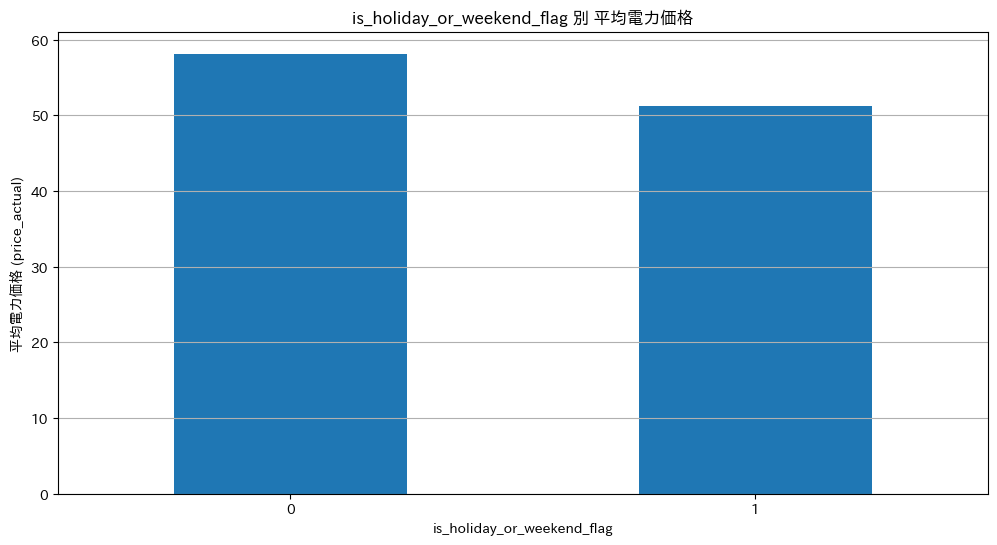

時間帯別 平均電力価格:


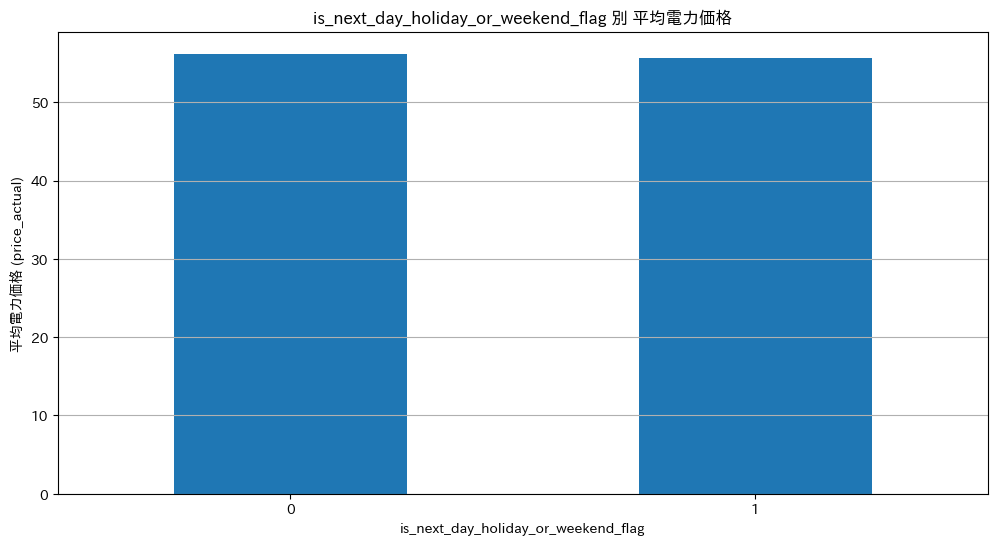

時間帯別 平均電力価格:


時間帯別 平均電力価格:


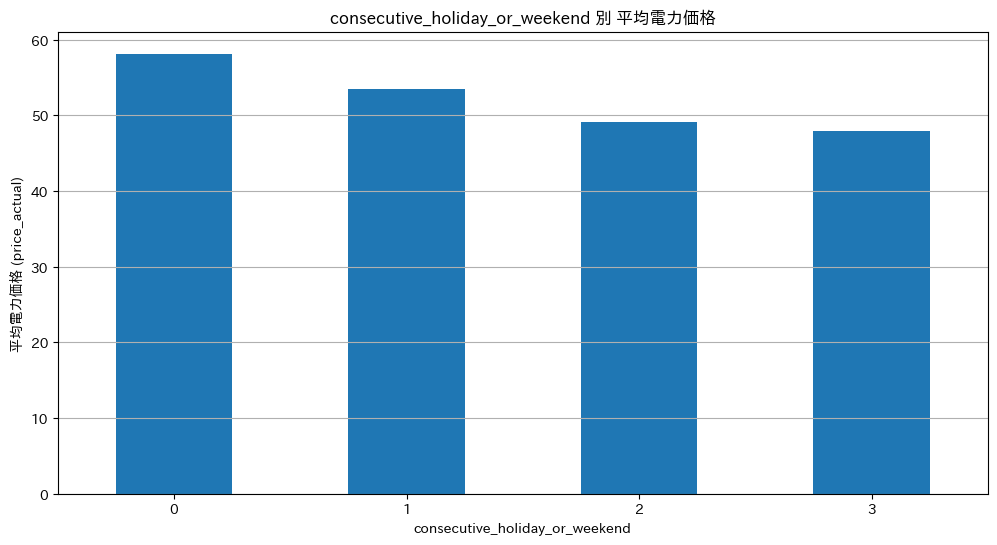

In [ ]:
# 追加した祝日フラグ毎の傾向を確認

# 各フラグ毎の傾向を見る
for col in add_column:
  plot_time_by_column(df_target, target_columns=target_var, group_column=col)

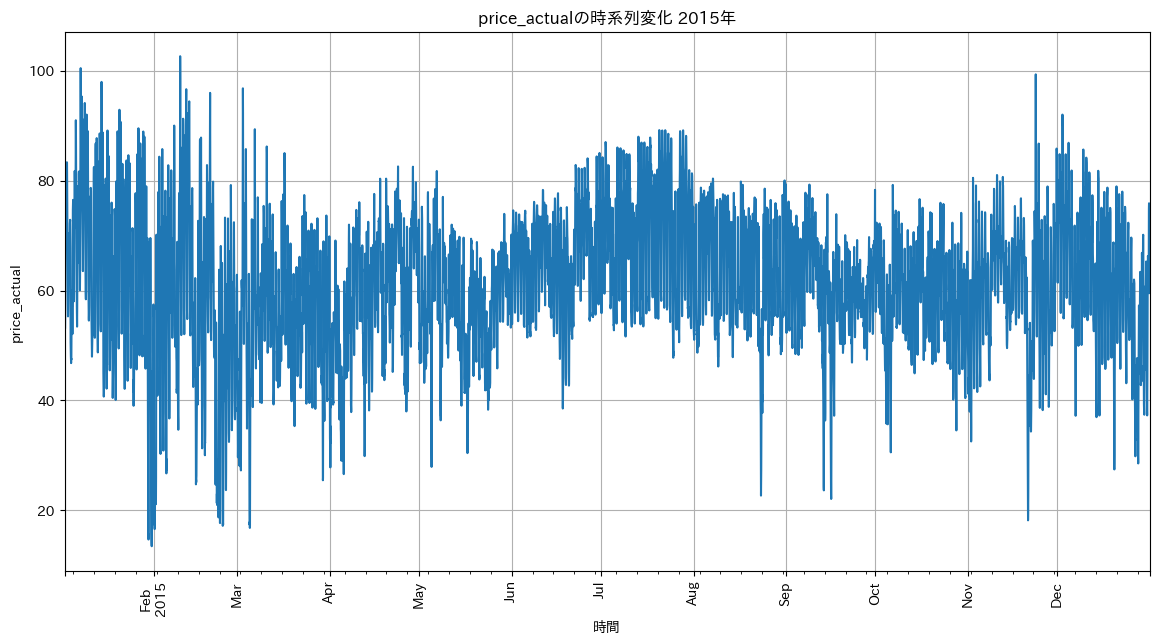

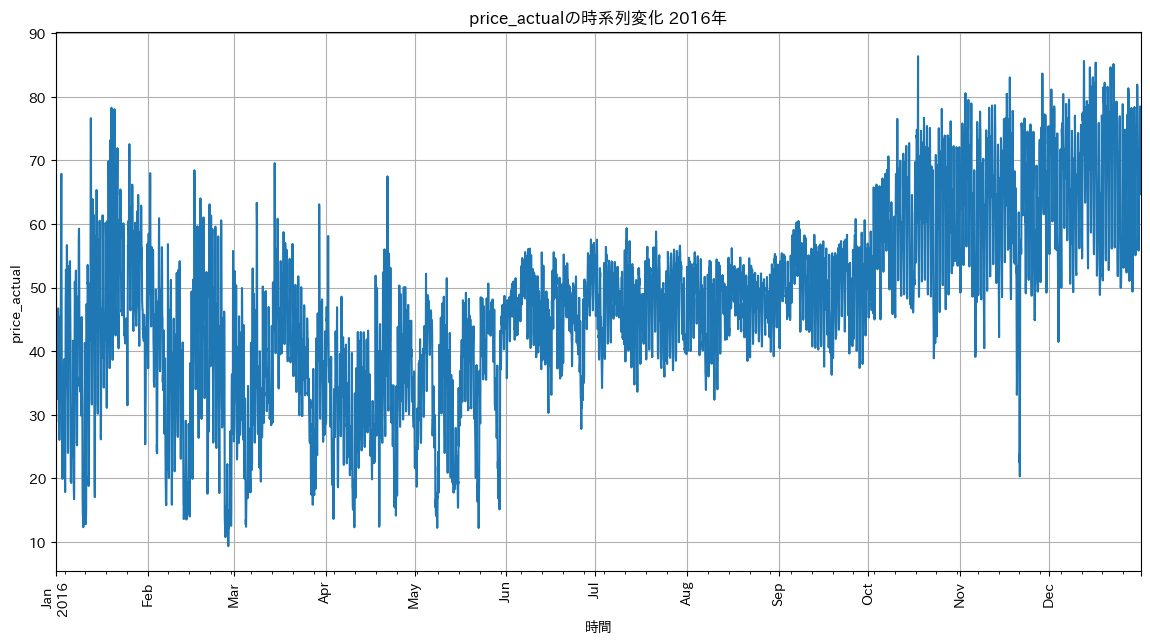

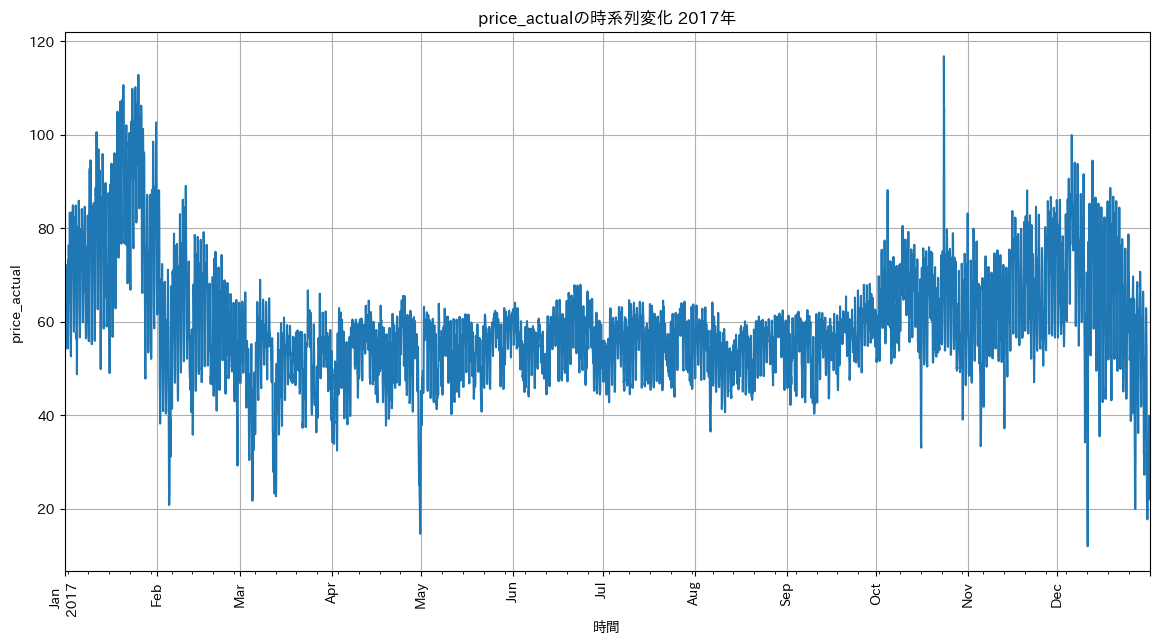

In [ ]:
# 年ごとに時系列の確認
# 時系列による散布図


for year in df_target['year'].unique().tolist():
  plt.figure(figsize=(14, 7))
  df_target[df_target['year']==year][target_var].plot()
  plt.title(f'price_actualの時系列変化 {year}年')
  plt.xlabel('時間')
  plt.ylabel(target_var)
  plt.xticks(rotation=90)
  plt.grid(True)
  plt.show()

In [ ]:
def add_lagged_group_mean(df, target_col='price_actual', group_list=[]):
  """
    時系列データに対し、リークを防ぐために過去の同じ属性の目的変数の平均を特徴量として追加します。

    Args:
        df (pd.DataFrame): 処理対象のデータフレーム。
        target_col (str): 目的変数のカラム名。デフォルトは 'price_actual'。
        time_col (str): 時系列のカラム名。 datetime型である必要があります。デフォルトは 'time'。

    Returns:
        pd.DataFrame: 新しい特徴量 'lagged_hourly_mean_' + target_col が追加されたデータフレーム。
  """
  # 時系列でソート
  df = df.sort_index()

  for group in group_list:
    if group in df.columns:
      df[f'agged_{group}_expanding_mean_' + target_col] = df.groupby([group])[target_col].transform(
          lambda x: x.shift(1).expanding().mean()
      )
    else:
      print(f'{group} カラムは含まれていません')
      continue
  return df

In [ ]:
# 各属性毎の平均値を入れる
group_column = time_columns + add_column
if 'year' in group_column:
  group_column.remove('year')
df_target = add_lagged_group_mean(df_target, target_col=target_var, group_list=group_column)
display(df_target.head())
print(df_target.shape)

generation_biomass  \
time                                            
2015-01-02 00:00:00+01:00               447.0   
2015-01-02 01:00:00+01:00               449.0   
2015-01-02 02:00:00+01:00               448.0   
2015-01-02 03:00:00+01:00               438.0   
2015-01-02 04:00:00+01:00               428.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2015-01-02 00:00:00+01:00                                 329.0   
2015-01-02 01:00:00+01:00                                 328.0   
2015-01-02 02:00:00+01:00                                 323.0   
2015-01-02 03:00:00+01:00                                 254.0   
2015-01-02 04:00:00+01:00                                 187.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2015-01-02 00:00:00+01:00                 4844.0                       4821.0   
2015-01-02 01:00:00+01:00                 5196.0                       4755.0   
2015-01-02 02:00:00+01:00                 4857.0                       4581.0   
2015-01-02 03:00:00+01:00                 4314.0                       4131.0   
2015-01-02 04:00:00+01:00                 4130.0                       3840.0   

                           generation_fossil_oil  \
time                                               
2015-01-02 00:00:00+01:00                  162.0   
2015-01-02 01:00:00+01:00                  158.0   
2015-01-02 02:00:00+01:00                  157.0   
2015-01-02 03:00:00+01:00                  160.0   
2015-01-02 04:00:00+01:00                  156.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2015-01-02 00:00:00+01:00                                        863.0   
2015-01-02 01:00:00+01:00                                        920.0   
2015-01-02 02:00:00+01:00                                       1164.0   
2015-01-02 03:00:00+01:00                                       1503.0   
2015-01-02 04:00:00+01:00                                       1826.0   

                           generation_hydro_run_of_river_and_poundage  \
time                                                                    
2015-01-02 00:00:00+01:00                                      1051.0   
2015-01-02 01:00:00+01:00                                      1009.0   
2015-01-02 02:00:00+01:00                                       973.0   
2015-01-02 03:00:00+01:00                                       949.0   
2015-01-02 04:00:00+01:00                                       953.0   

                           generation_hydro_water_reservoir  \
time                                                          
2015-01-02 00:00:00+01:00                            1899.0   
2015-01-02 01:00:00+01:00                            1658.0   
2015-01-02 02:00:00+01:00                            1371.0   
2015-01-02 03:00:00+01:00                             779.0   
2015-01-02 04:00:00+01:00                             720.0   

                           generation_nuclear  generation_other  ...  \
time                                                             ...   
2015-01-02 00:00:00+01:00              7096.0              43.0  ...   
2015-01-02 01:00:00+01:00              7096.0              43.0  ...   
2015-01-02 02:00:00+01:00              7099.0              43.0  ...   
2015-01-02 03:00:00+01:00              7098.0              43.0  ...   
2015-01-02 04:00:00+01:00              7097.0              43.0  ...   

                           is_previous_day_holiday_or_weekend_flag  \
time                                                                 
2015-01-02 00:00:00+01:00                                        1   
2015-01-02 01:00:00+01:00                                        1   
2015-01-02 02:00:00+01

(26280, 108)


In [ ]:
def check_missing_values(df):
    """
    データフレームの欠損値を確認し、各カラムの欠損数と割合を表示する。

    Args:
        df (pd.DataFrame): チェック対象のデータフレーム。
    """
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    missing_info = pd.DataFrame({
        'Missing Count': missing_values,
        'Missing Percentage (%)': missing_percentage
    })

    # 欠損値が0より大きいカラムのみを表示
    missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

    print("欠損値の確認:")
    if missing_info.empty:
        print("欠損値はありません。")
    else:
        display(missing_info)

In [ ]:
# 欠損値チェック
check_missing_values(df_target)

欠損値の確認:


Missing Count  \
total_load_actual                                              37   
agged_day_expanding_mean_price_actual                          31   
agged_hour_expanding_mean_price_actual                         24   
generation_hydro_run_of_river_and_poundage                     21   
generation_biomass                                             21   
generation_hydro_pumped_storage_consumption                    21   
generation_fossil_oil                                          21   
generation_waste                                               21   
generation_fossil_hard_coal                                    20   
generation_fossil_brown_coal/lignite                           20   
generation_fossil_gas                                          20   
generation_solar                                               20   
generation_other_renewable                                     20   
generation_hydro_water_reservoir                               20   
generation_other                                               20   
generation_wind_onshore                                        20   
generation_nuclear                                             19   
agged_month_expanding_mean_price_actual                        12   
agged_dayofweek_expanding_mean_price_actual                     7   
agged_consecutive_holiday_or_weekend_expanding_...              4   
agged_is_holiday_or_weekend_flag_expanding_mean...              2   
agged_is_next_day_holiday_or_weekend_flag_expan...              2   
agged_is_previous_day_holiday_or_weekend_flag_e...              2   

                                                    Missing Percentage (%)  
total_load_actual                                                 0.140791  
agged_day_expanding_mean_price_actual                             0.117960  
agged_hour_expanding_mean_price_actual                            0.091324  
generation_hydro_run_of_river_and_poundage                        0.079909  
generation_biomass                                                0.079909  
generation_hydro_pumped_storage_consumption                       0.079909  
generation_fossil_oil                                             0.079909  
generation_waste                                                  0.079909  
generation_fossil_hard_coal                                       0.076104  
generation_fossil_brown_coal/lignite                              0.076104  
generation_fossil_gas                                             0.076104  
generation_solar                                                  0.076104  
generation_other_renewable                                        0.076104  
generation_hydro_water_reservoir                                  0.076104  
generation_other                                                  0.076104  
generation_wind_onshore                                           0.076104  
generation_nuclear                                                0.072298  
agged_month_expanding_mean_price_actual                           0.045662  
agged_dayofweek_expanding_mean_price_actual                       0.026636  
agged_consecutive_holiday_or_weekend_expanding_...                0.015221  
agged_is_holiday_or_weekend_flag_expanding_mean...                0.007610  
agged_is_next_day_holiday_or_weekend_flag_expan...                0.007610  
agged_is_previous_day_holiday_or_weekend_flag_e...                0.007610

In [ ]:
def plot_correlations(df, target_column='price_actual', figsize=(12, 10)):
  """
    データフレーム内の数値カラムとターゲットカラムとの相関行列をヒートマップで表示します。

    Args:
        df (pd.DataFrame): 相関を計算するデータフレーム。
        target_column (str): 相関を見たいターゲットカラムの名前。デフォルトは 'price_actual'。
        figsize (tuple): ヒートマップのフィギュアサイズ。デフォルトは (12, 10)。
  """
  # 数値カラムのみを選択
  numeric_cols = df.select_dtypes(include=np.number).columns

  if target_column not in numeric_cols:
    print(f"ターゲットカラム '{target_column}' が数値カラムに含まれていません。")
    return

  # ターゲットカラムを含む数値カラムのみで相関行列を計算
  correlation_matrix = df[numeric_cols].corr()

  # ターゲットカラムとの相関を抽出してソート
  target_correlation = correlation_matrix[target_column].sort_values(ascending=False)

  print(f"\n'{target_column}' と各数値カラムの相関:")
  print(target_correlation)

  # 相関行列全体をヒートマップで表示 (任意)
  plt.figure(figsize=figsize)
  sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
  plt.title('各カラム間の相関行列')
  plt.show()

  # ターゲットカラムとの相関のみを棒グラフで表示 (見やすいように)
  plt.figure(figsize=(10, len(target_correlation) * 0.4)) # フィギュアサイズを調整
  target_correlation.drop(target_column).plot(kind='barh') # ターゲット自身との相関(1.0)は除く
  plt.title(f"'{target_column}' と他のカラムの相関")
  plt.xlabel('相関係数')
  plt.ylabel('カラム名')
  plt.grid(axis='x')
  plt.show()


'price_actual' と各数値カラムの相関:
price_actual                                   1.000000
generation_fossil_hard_coal                    0.468860
agged_month_expanding_mean_price_actual        0.435468
agged_hour_expanding_mean_price_actual         0.416416
generation_fossil_brown_coal/lignite           0.375490
                                                 ...   
consecutive_holiday_or_weekend                -0.237077
generation_hydro_run_of_river_and_poundage    -0.260662
generation_hydro_pumped_storage_consumption   -0.302043
barcelona_snow_3h                                   NaN
seville_snow_3h                                     NaN
Name: price_actual, Length: 108, dtype: float64


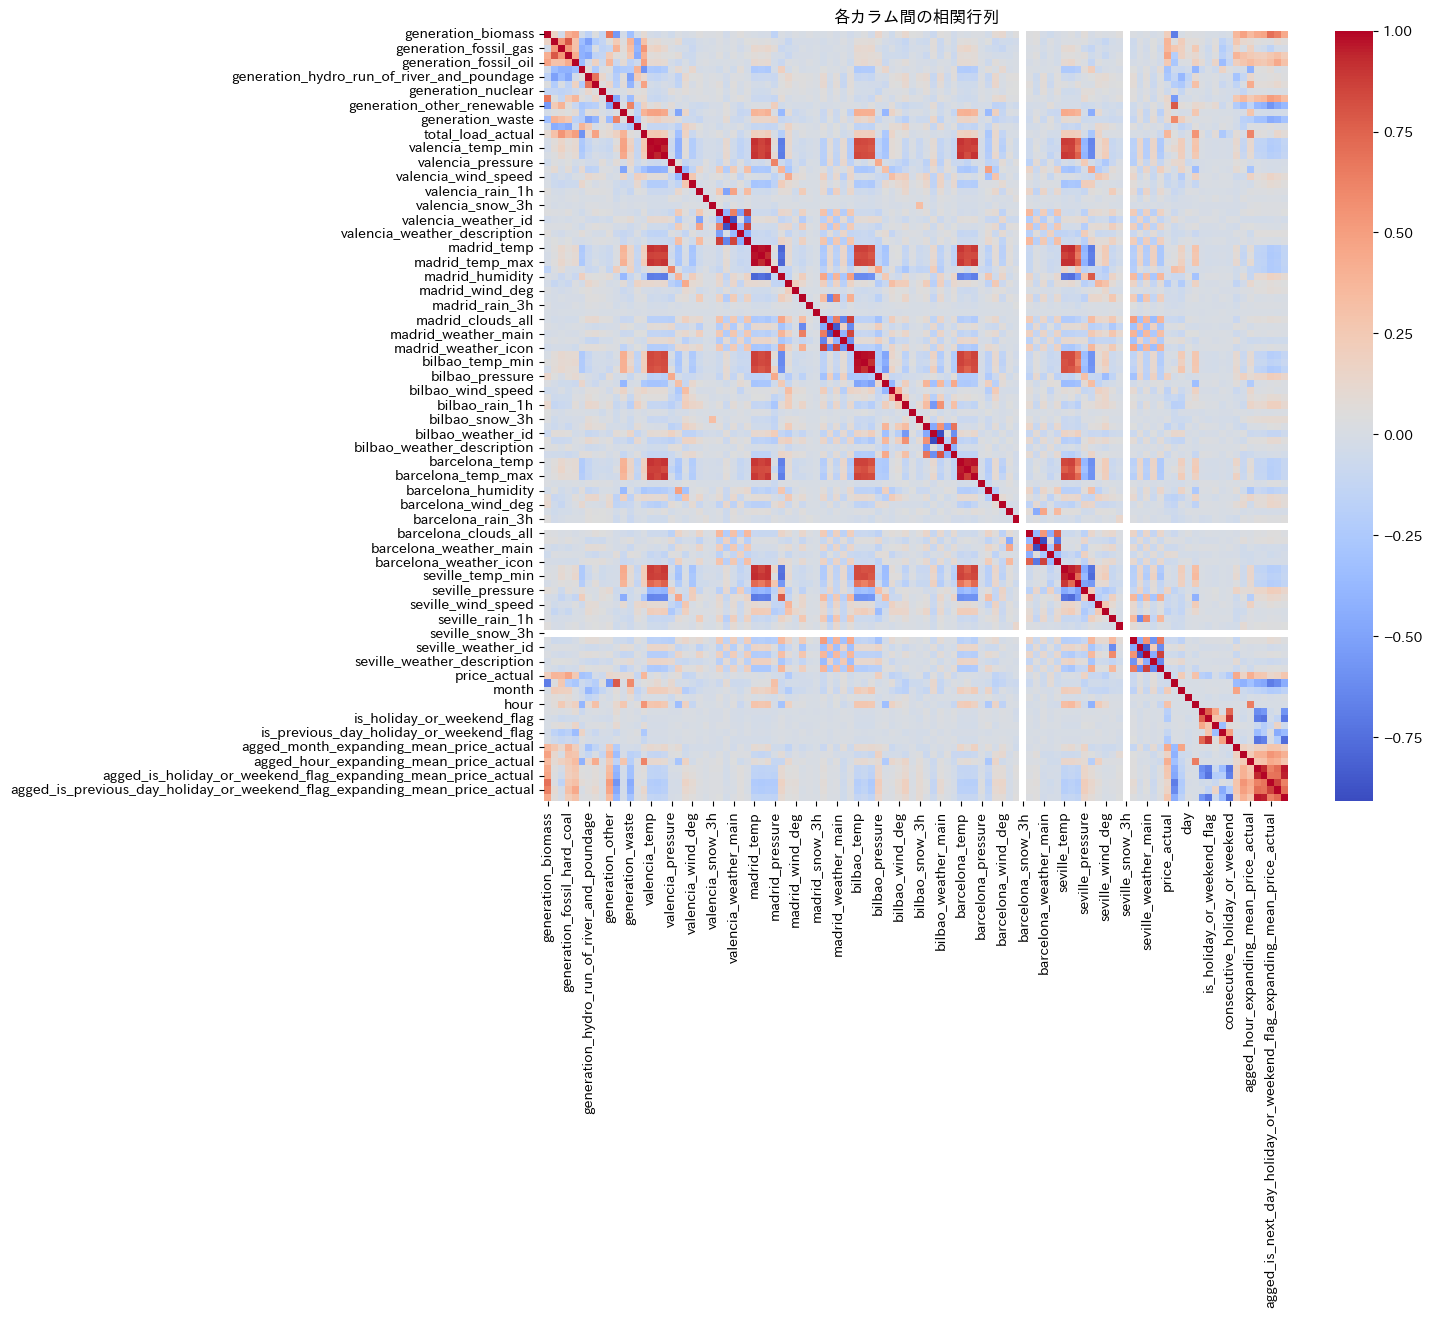

In [ ]:
# 相関を見る関数を実行
plot_correlations(df_target, target_column='price_actual')

In [ ]:
def convert_missing_to_minus_one(df):
  """
  データフレーム内の欠損値 (NaN) を -1 または文字列 '-1' に変換します。
  数値型カラムの欠損値は数値の -1 に、オブジェクト型カラムの欠損値は文字列 '-1' に変換します。

  Args:
    df (pd.DataFrame): 処理対象のデータフレーム。

  Returns:
    pd.DataFrame: 欠損値が変換されたデータフレーム。
  """
  df_copy = df.copy() # 元のデータフレームを変更しないためにコピーを作成

  for col in df_copy.columns:
    if df_copy[col].dtype in ['int64', 'float64']: # 数値型の場合
      df_copy[col].fillna(-1, inplace=True)
    elif df_copy[col].dtype == 'object': # オブジェクト型 (文字列など) の場合
      df_copy[col].fillna('-1', inplace=True)

  return df_copy

In [ ]:
# メモ
#fillnaもしくはffillで欠損値補完

In [ ]:
# prompt: 相関が高い上位20個を抽出して、そのカラム名を取得してください。

# 'price_actual' との相関を計算
correlation_with_target = df_target.select_dtypes(include=np.number).corr()['price_actual'].sort_values(ascending=False)

# ターゲットカラム自身 (相関1.0) を除く
correlation_with_target = correlation_with_target.drop('price_actual')

# 相関が高い上位20個を抽出
top_20_correlations = correlation_with_target.head(20)

# 上位20個のカラム名を取得
top_20_columns = top_20_correlations.index.tolist()

print("相関が高い上位20個のカラム名:")
top_20_columns

相関が高い上位20個のカラム名:


['generation_fossil_hard_coal',
 'agged_month_expanding_mean_price_actual',
 'agged_hour_expanding_mean_price_actual',
 'generation_fossil_brown_coal/lignite',
 'total_load_actual',
 'generation_fossil_gas',
 'hour',
 'agged_consecutive_holiday_or_weekend_expanding_mean_price_actual',
 'agged_dayofweek_expanding_mean_price_actual',
 'agged_is_holiday_or_weekend_flag_expanding_mean_price_actual',
 'generation_fossil_oil',
 'month',
 'generation_biomass',
 'bilbao_pressure',
 'seville_pressure',
 'agged_is_previous_day_holiday_or_weekend_flag_expanding_mean_price_actual',
 'agged_day_expanding_mean_price_actual',
 'agged_is_next_day_holiday_or_weekend_flag_expanding_mean_price_actual',
 'generation_other',
 'generation_other_renewable']

In [ ]:
# 相関が高い上位に絞る
#df_target = df_target[top_20_columns + ['price_actual']]
df_target.head()

generation_biomass  \
time                                            
2015-01-02 00:00:00+01:00               447.0   
2015-01-02 01:00:00+01:00               449.0   
2015-01-02 02:00:00+01:00               448.0   
2015-01-02 03:00:00+01:00               438.0   
2015-01-02 04:00:00+01:00               428.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2015-01-02 00:00:00+01:00                                 329.0   
2015-01-02 01:00:00+01:00                                 328.0   
2015-01-02 02:00:00+01:00                                 323.0   
2015-01-02 03:00:00+01:00                                 254.0   
2015-01-02 04:00:00+01:00                                 187.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2015-01-02 00:00:00+01:00                 4844.0                       4821.0   
2015-01-02 01:00:00+01:00                 5196.0                       4755.0   
2015-01-02 02:00:00+01:00                 4857.0                       4581.0   
2015-01-02 03:00:00+01:00                 4314.0                       4131.0   
2015-01-02 04:00:00+01:00                 4130.0                       3840.0   

                           generation_fossil_oil  \
time                                               
2015-01-02 00:00:00+01:00                  162.0   
2015-01-02 01:00:00+01:00                  158.0   
2015-01-02 02:00:00+01:00                  157.0   
2015-01-02 03:00:00+01:00                  160.0   
2015-01-02 04:00:00+01:00                  156.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2015-01-02 00:00:00+01:00                                        863.0   
2015-01-02 01:00:00+01:00                                        920.0   
2015-01-02 02:00:00+01:00                                       1164.0   
2015-01-02 03:00:00+01:00                                       1503.0   
2015-01-02 04:00:00+01:00                                       1826.0   

                           generation_hydro_run_of_river_and_poundage  \
time                                                                    
2015-01-02 00:00:00+01:00                                      1051.0   
2015-01-02 01:00:00+01:00                                      1009.0   
2015-01-02 02:00:00+01:00                                       973.0   
2015-01-02 03:00:00+01:00                                       949.0   
2015-01-02 04:00:00+01:00                                       953.0   

                           generation_hydro_water_reservoir  \
time                                                          
2015-01-02 00:00:00+01:00                            1899.0   
2015-01-02 01:00:00+01:00                            1658.0   
2015-01-02 02:00:00+01:00                            1371.0   
2015-01-02 03:00:00+01:00                             779.0   
2015-01-02 04:00:00+01:00                             720.0   

                           generation_nuclear  generation_other  ...  \
time                                                             ...   
2015-01-02 00:00:00+01:00              7096.0              43.0  ...   
2015-01-02 01:00:00+01:00              7096.0              43.0  ...   
2015-01-02 02:00:00+01:00              7099.0              43.0  ...   
2015-01-02 03:00:00+01:00              7098.0              43.0  ...   
2015-01-02 04:00:00+01:00              7097.0              43.0  ...   

                           is_previous_day_holiday_or_weekend_flag  \
time                                                                 
2015-01-02 00:00:00+01:00                                        1   
2015-01-02 01:00:00+01:00                                        1   
2015-01-02 02:00:00+01

## データセット分割

In [ ]:
# 学習前に過学習を起こしそうなカラムを削除する
print(df_target.info())
delete_column = ['price_actual', 'forecast_price_day_ahead', 'forecast_date', 'time', 'forecast_time']
#df_target = df_target.drop(delete_column, errors='ignore')
print(df_target.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2015-01-02 00:00:00+01:00 to 2017-12-31 23:00:00+01:00
Columns: 108 entries, generation_biomass to agged_consecutive_holiday_or_weekend_expanding_mean_price_actual
dtypes: float64(54), int32(5), int64(49)
memory usage: 21.4 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2015-01-02 00:00:00+01:00 to 2017-12-31 23:00:00+01:00
Columns: 108 entries, generation_biomass to agged_consecutive_holiday_or_weekend_expanding_mean_price_actual
dtypes: float64(54), int32(5), int64(49)
memory usage: 21.4 MB
None


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# 欠損値補完
# 前方補完
df_model = df_target.interpolate('ffill')
# 初期値が欠損値の場合は補完されないため、残りの補完
df_model = convert_missing_to_minus_one(df_model)
print('欠損値を補完しました。')
# 欠損値の確認
check_missing_values(df_model)

# インデックスで並び替え
df_model = df_model.sort_index()

# 目的変数と特徴量の定義
target = 'price_actual'
features = [col for col in df_model.columns if col != target and df_model[col].dtype in [np.number]]

X = df_model[features]
y = df_model[target]

# データの時間でソートされていることを確認
df_model = df_model.sort_index()

# バリデーション用セットは2017年とする
val_year = 2017

X_train = X[df_model.index.year < val_year]
y_train = y[df_model.index.year < val_year]
X_val = X[df_model.index.year == val_year]
y_val = y[df_model.index.year == val_year]

print("学習データの形状:", X_train.shape, y_train.shape)
print("テストデータの形状:", X_val.shape, y_val.shape)

欠損値を補完しました。
欠損値の確認:
欠損値はありません。
学習データの形状: (17520, 53) (17520,)
テストデータの形状: (8760, 53) (8760,)


In [ ]:
# 目的変数 'price_actual' が存在することを確認
if 'price_actual' in df_model.columns:
    print("\nデータセットの時間範囲:")
    print(f"学習開始時間: {X_train.index.min()}")
    print(f"学習終了時間: {X_train.index.max()}")
    print(f"評価開始時間: {X_val.index.min()}")
    print(f"評価終了時間: {X_val.index.max()}")


データセットの時間範囲:
学習開始時間: 2015-01-02 00:00:00+01:00
学習終了時間: 2016-12-31 23:00:00+01:00
評価開始時間: 2017-01-01 00:00:00+01:00
評価終了時間: 2017-12-31 23:00:00+01:00


In [ ]:
# カスタムコールバック関数の定義
# この関数は、lgb.trainのcallbacks引数に渡すための関数を返す関数です。
def custom_evaluation_callback(history_dict):
    def _callback(env):
        # env.evaluation_result_list に現在のラウンドの評価結果が含まれる
        # 例: [('training', 'rmse', 0.1234, False), ('valid_0', 'rmse', 0.1256, False)]
        for data_name, metric_name, value, _ in env.evaluation_result_list:
            # 辞書に評価結果を記録
            if data_name not in history_dict:
                history_dict[data_name] = {}
            if metric_name not in history_dict[data_name]:
                history_dict[data_name][metric_name] = []
            history_dict[data_name][metric_name].append(value)

    return _callback

## モデルの学習

4.6.0

--- LightGBMモデル ---
バリデーションデータでのRMSE: 12.904828054085067

特徴量の重要度:


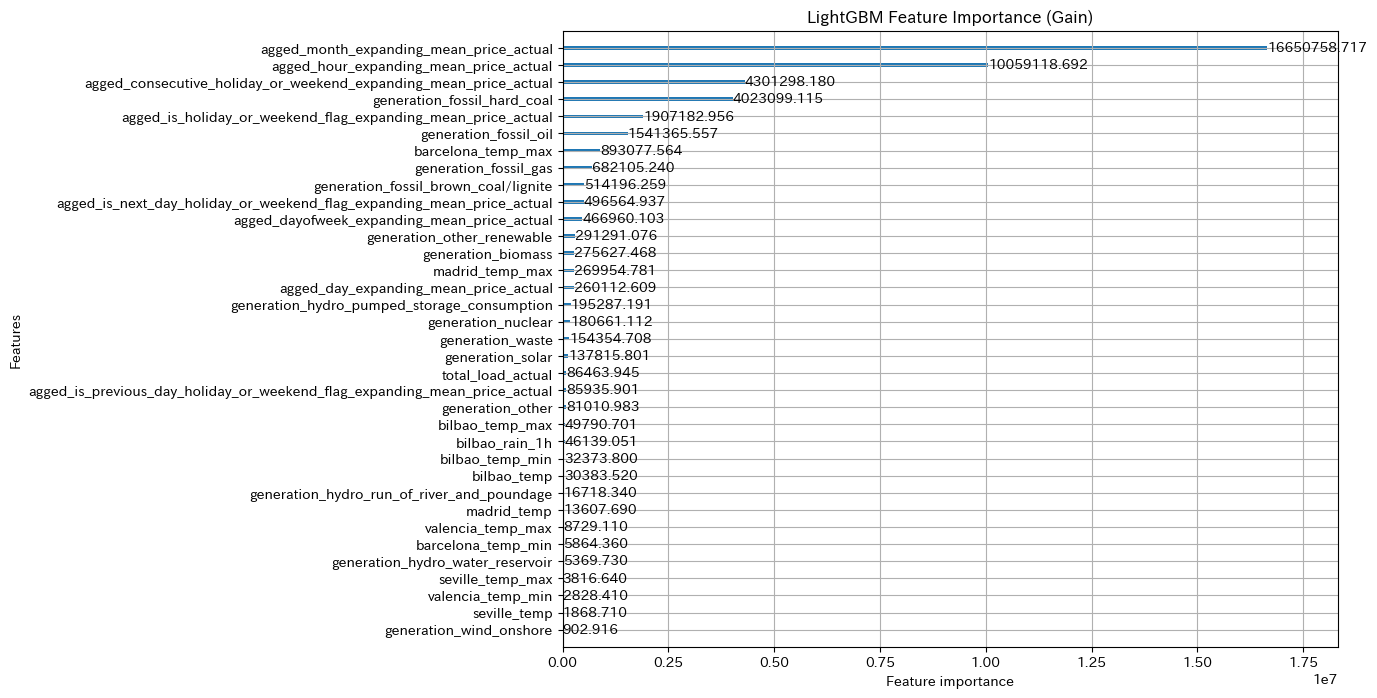

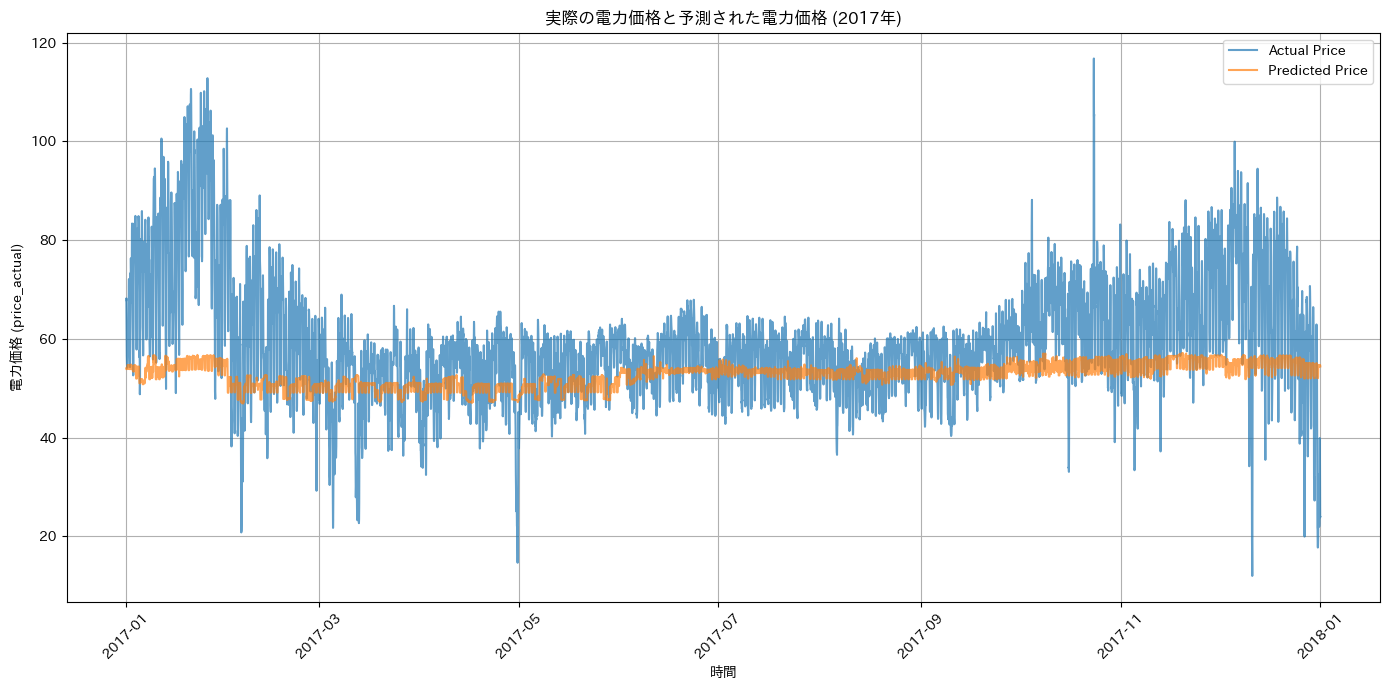


--- 学習曲線 (カスタムコールバック使用) ---


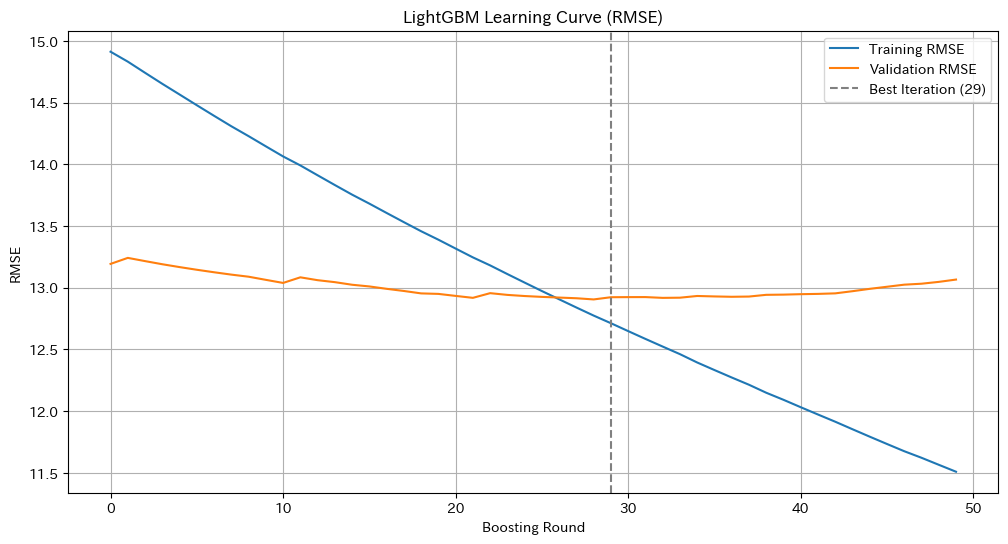

In [ ]:
# prompt: 評価指標はrmseでモデルの学習はlightgbmで、時系列データであることに注意してバリデーションを行ってください。

import lightgbm as lgb
print(lgb.__version__)
# LightGBMモデルの定義
params = {
    'objective': 'regression_l2',  # regression_l1
    'metric': 'rmse',
    'n_estimators': 50,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1,
    'max_depth': 5,
    'min_child_samples':20,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'seed': 42
}
# LightGBMモデルの構築と学習
print("\n--- LightGBMモデル ---")
# LightGBMのデータセット形式に変換
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# early_stopping コールバックをリスト内に定義し、そのインスタンスを保持
early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=False)
# 評価結果を格納するための辞書を準備
evaluation_history = {
    'training': {'rmse': []},
    'valid_0': {'rmse': []} # lgb_val に対応。もしvalid_setsの順序が変わるなら調整
}
# モデル学習 (early stoppingを使用)
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=10000, # 試行回数を多めに設定
    #categorical_feature=object_cols_train,
    valid_sets=[lgb_val, lgb_train],
    callbacks=[early_stopping_callback,
               lgb.log_evaluation(period=100),
               custom_evaluation_callback(evaluation_history)]
    ) # 50回改善が見られなければ停止

# バリデーションデータでの予測
y_pred = model.predict(X_val)

# 評価 (RMSE)
rmse = root_mean_squared_error(y_val, y_pred)

print(f"バリデーションデータでのRMSE: {rmse}")

# --- 学習曲線のプロット ---
print("\n--- 学習曲線 (カスタムコールバック使用) ---")
plt.figure(figsize=(12, 6))

# evaluation_history 辞書からデータを取得してプロット
# キー名が 'valid_0', 'training' であることを確認してください
if 'training' in evaluation_history and 'rmse' in evaluation_history['training']:
    plt.plot(evaluation_history['training']['rmse'], label='Training RMSE')
if 'valid_0' in evaluation_history and 'rmse' in evaluation_history['valid_0']:
    plt.plot(evaluation_history['valid_0']['rmse'], label='Validation RMSE')

# 最適なイテレーションに線を引く
# model.best_iteration は early_stopping_callback が設定されていれば利用可能
plt.axvline(x=model.best_iteration, color='gray', linestyle='--', label=f'Best Iteration ({model.best_iteration})')

plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('LightGBM Learning Curve (RMSE)')
plt.legend()
plt.grid(True)
plt.show()

# 特徴量の重要度を表示
print("\n特徴量の重要度:")
lgb.plot_importance(model, importance_type='gain', figsize=(10, 8))
plt.title('LightGBM Feature Importance (Gain)')
plt.show()

# 実際の値と予測値の比較をプロット
plt.figure(figsize=(14, 7))
plt.plot(y_val.index, y_val, label='Actual Price', alpha=0.7)
plt.plot(y_val.index, y_pred, label='Predicted Price', alpha=0.7)
plt.title('実際の電力価格と予測された電力価格 (2017年)')
plt.xlabel('時間')
plt.ylabel('電力価格 (price_actual)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

データ総数: 26280
初期訓練サイズ: 5256
検証サイズ (各ステップ): 2628
推定分割数: 8

--- Fold 1/8 ---
訓練データ期間: 2015-01-02 00:00:00+01:00 - 2015-08-09 00:00:00+02:00 (サイズ: 5256)
検証データ期間: 2015-08-09 01:00:00+02:00 - 2015-11-26 11:00:00+01:00 (サイズ: 2628)
Fold 1 RMSE: 8.2592


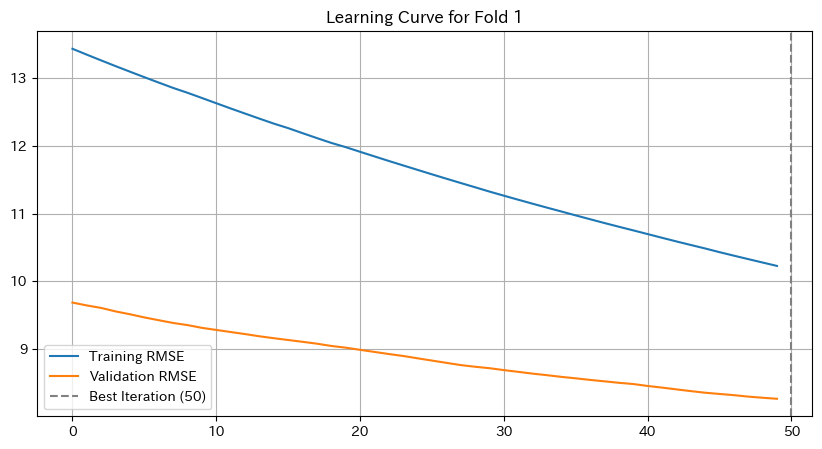

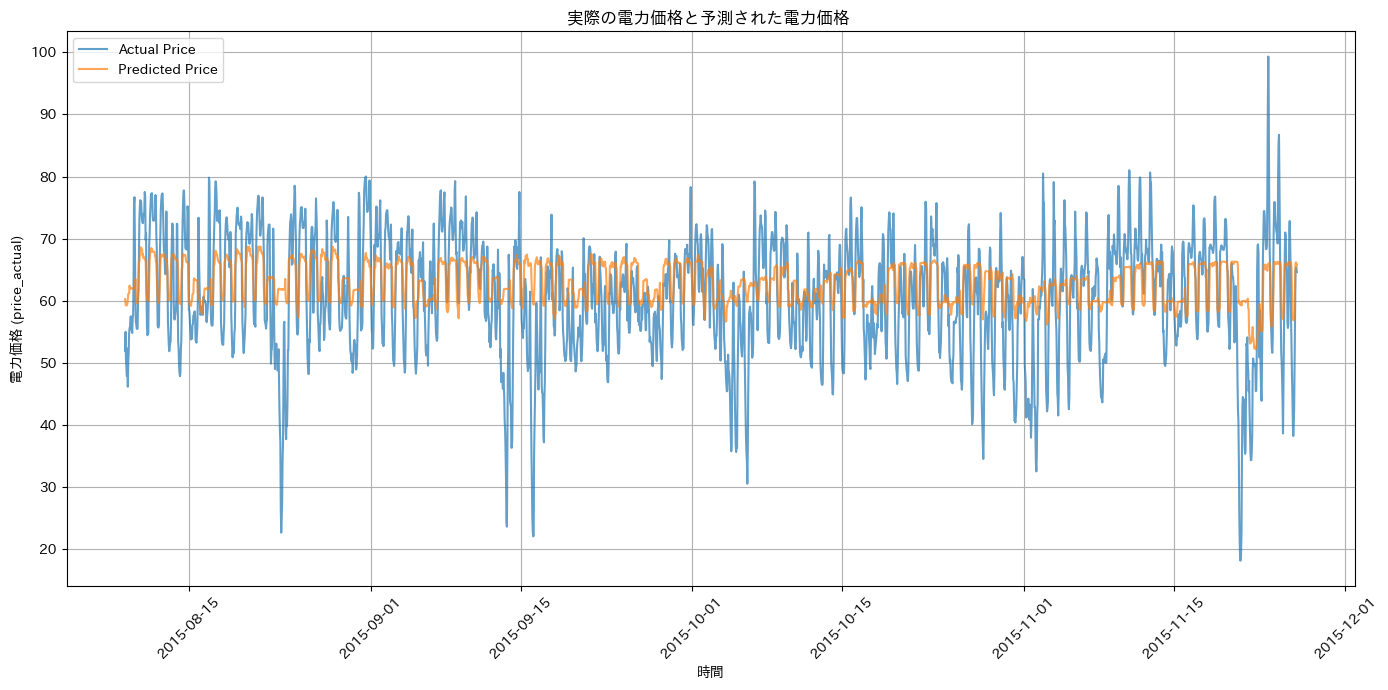


--- Fold 2/8 ---
訓練データ期間: 2015-01-02 00:00:00+01:00 - 2015-11-26 11:00:00+01:00 (サイズ: 7884)
検証データ期間: 2015-11-26 12:00:00+01:00 - 2016-03-14 23:00:00+01:00 (サイズ: 2628)
Fold 2 RMSE: 19.6121


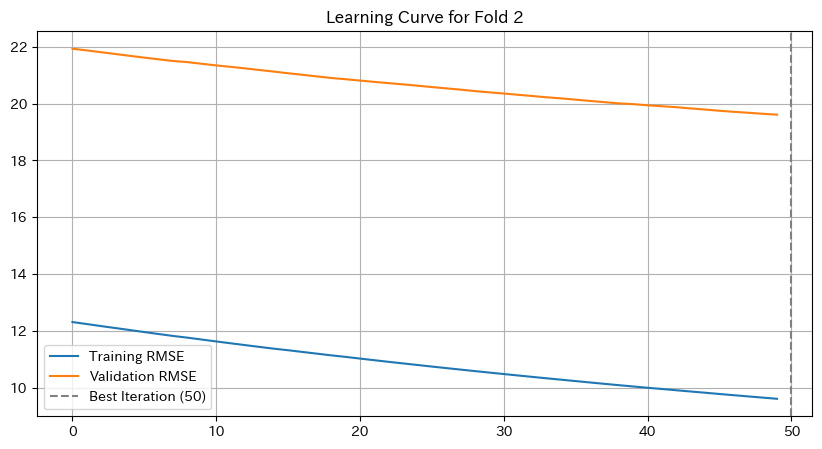

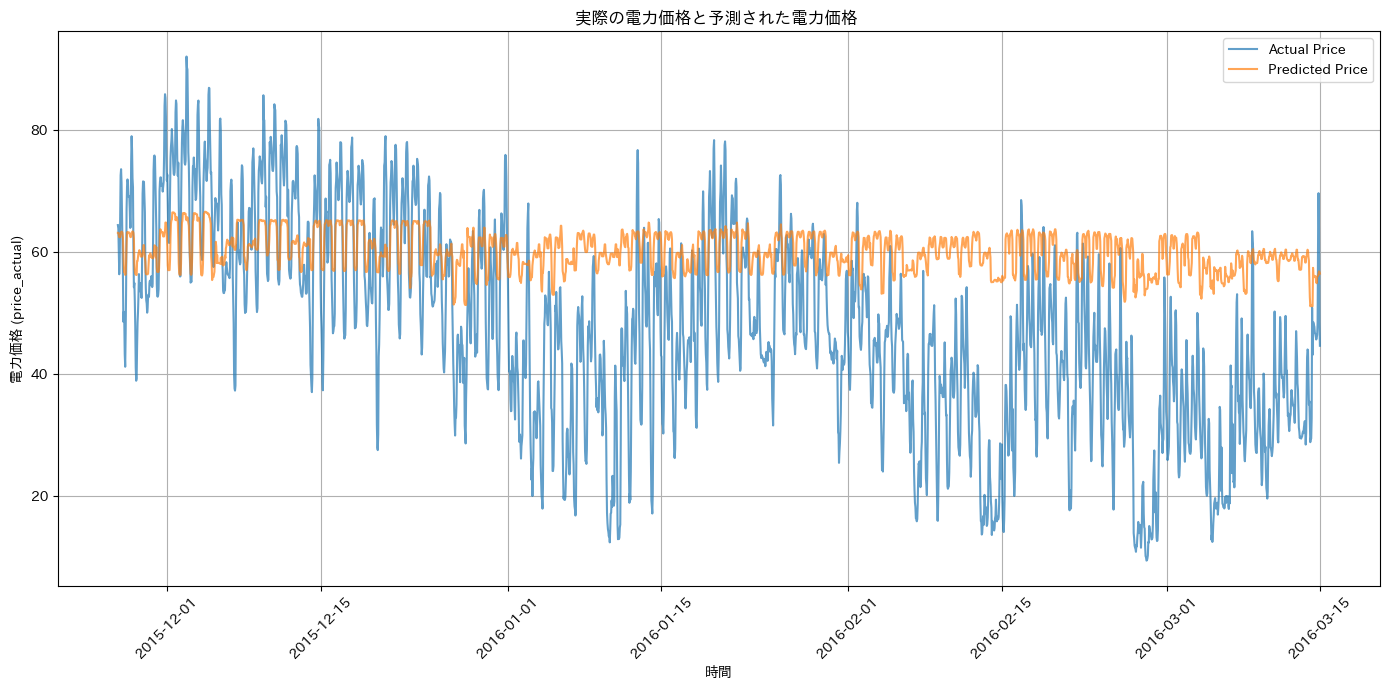


--- Fold 3/8 ---
訓練データ期間: 2015-01-02 00:00:00+01:00 - 2016-03-14 23:00:00+01:00 (サイズ: 10512)
検証データ期間: 2016-03-15 00:00:00+01:00 - 2016-07-02 12:00:00+02:00 (サイズ: 2628)
Fold 3 RMSE: 16.1281


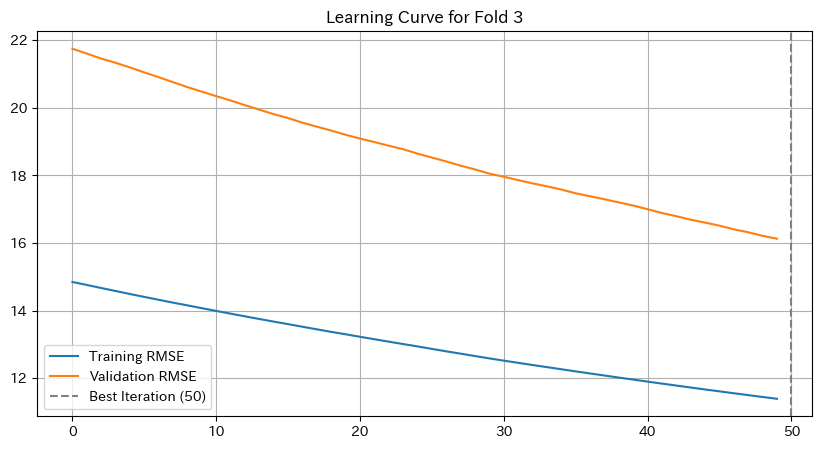

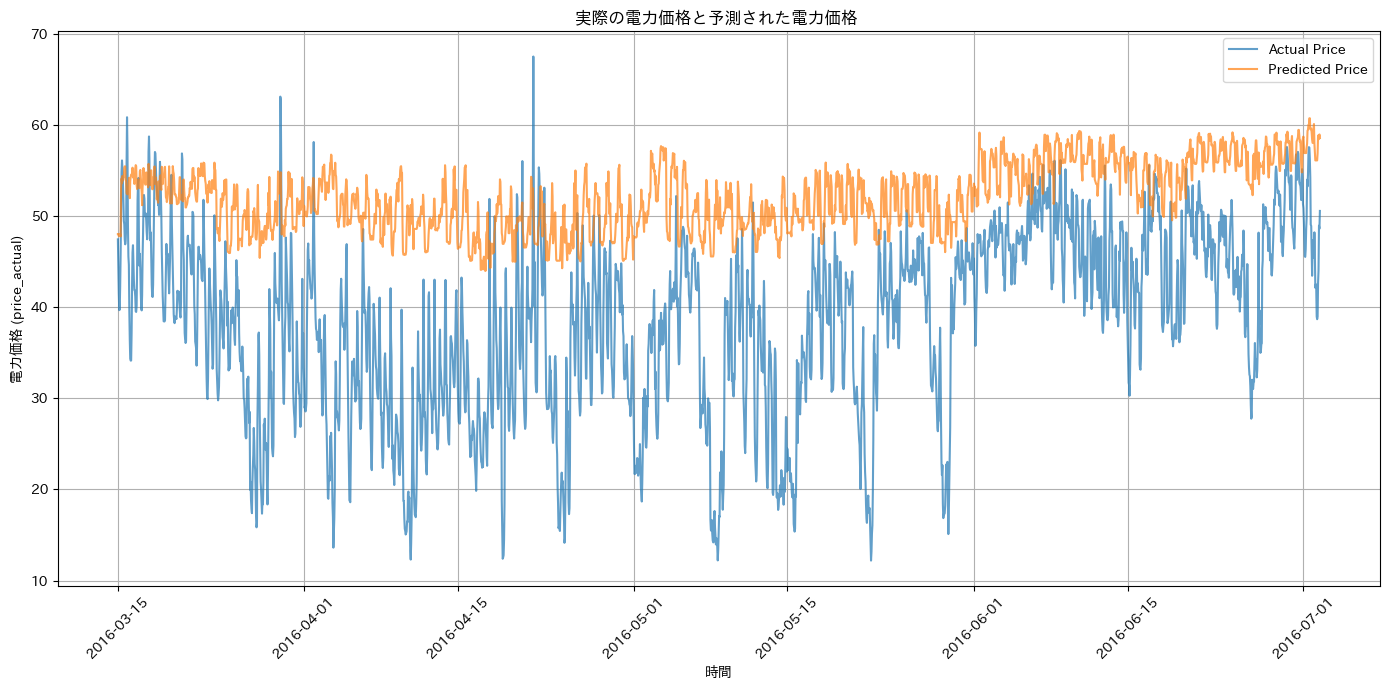


--- Fold 4/8 ---
訓練データ期間: 2015-01-02 00:00:00+01:00 - 2016-07-02 12:00:00+02:00 (サイズ: 13140)
検証データ期間: 2016-07-02 13:00:00+02:00 - 2016-10-20 00:00:00+02:00 (サイズ: 2628)
Fold 4 RMSE: 7.3001


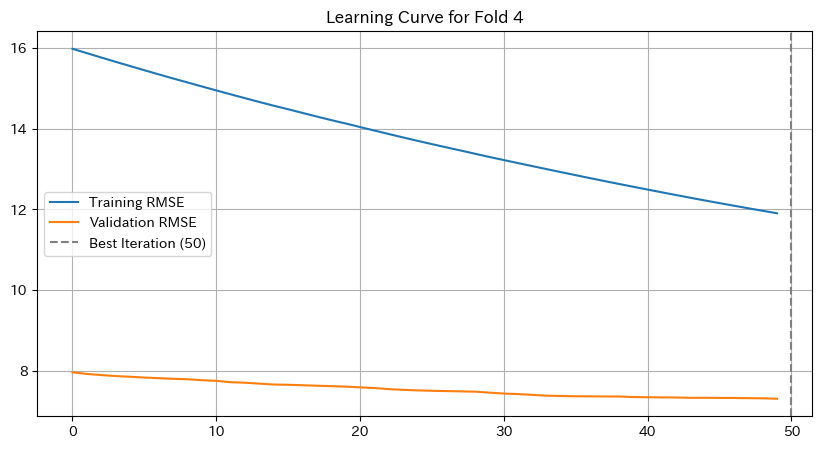


--- Fold 5/8 ---
訓練データ期間: 2015-01-02 00:00:00+01:00 - 2016-10-20 00:00:00+02:00 (サイズ: 15768)
検証データ期間: 2016-10-20 01:00:00+02:00 - 2017-02-06 11:00:00+01:00 (サイズ: 2628)
Fold 5 RMSE: 20.4846


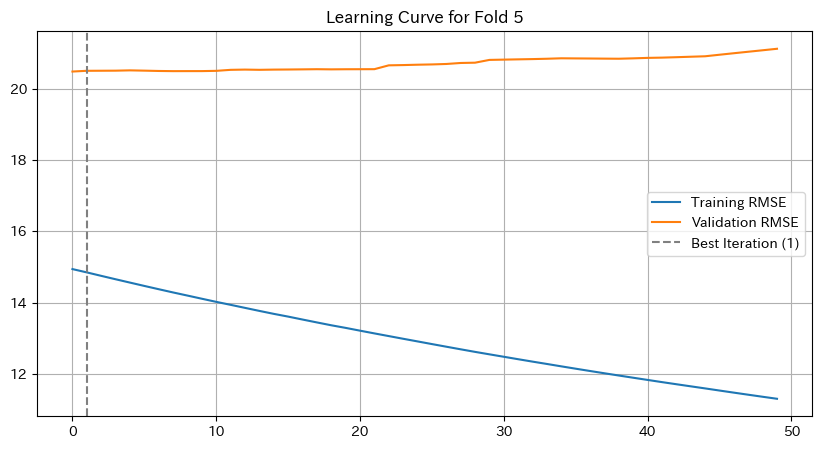


--- Fold 6/8 ---
訓練データ期間: 2015-01-02 00:00:00+01:00 - 2017-02-06 11:00:00+01:00 (サイズ: 18396)
検証データ期間: 2017-02-06 12:00:00+01:00 - 2017-05-27 00:00:00+02:00 (サイズ: 2628)
Fold 6 RMSE: 8.4978


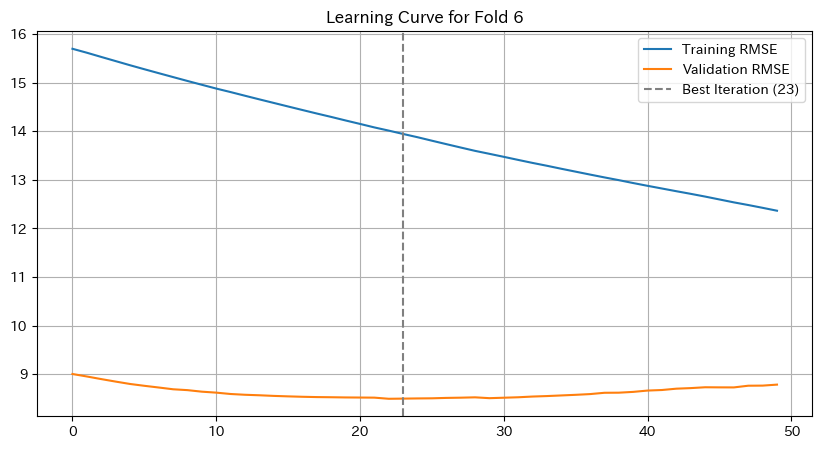

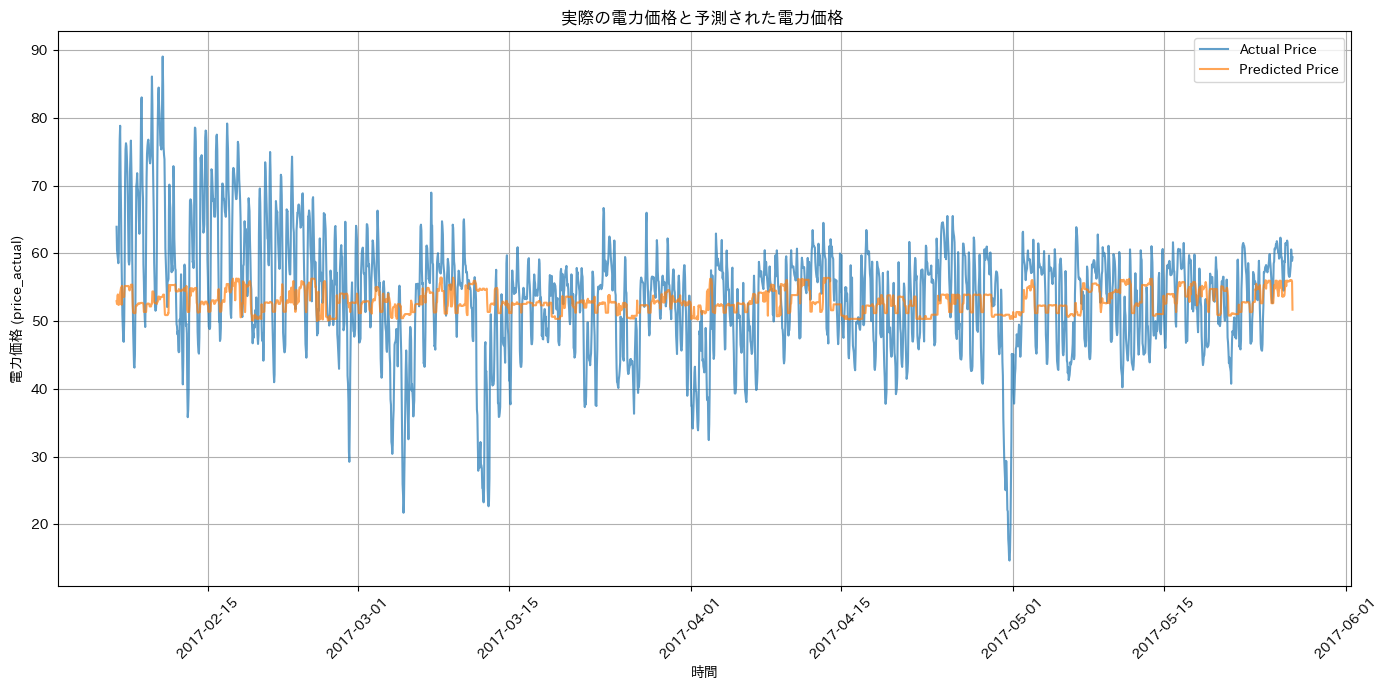


--- Fold 7/8 ---
訓練データ期間: 2015-01-02 00:00:00+01:00 - 2017-05-27 00:00:00+02:00 (サイズ: 21024)
検証データ期間: 2017-05-27 01:00:00+02:00 - 2017-09-13 12:00:00+02:00 (サイズ: 2628)
Fold 7 RMSE: 4.6757


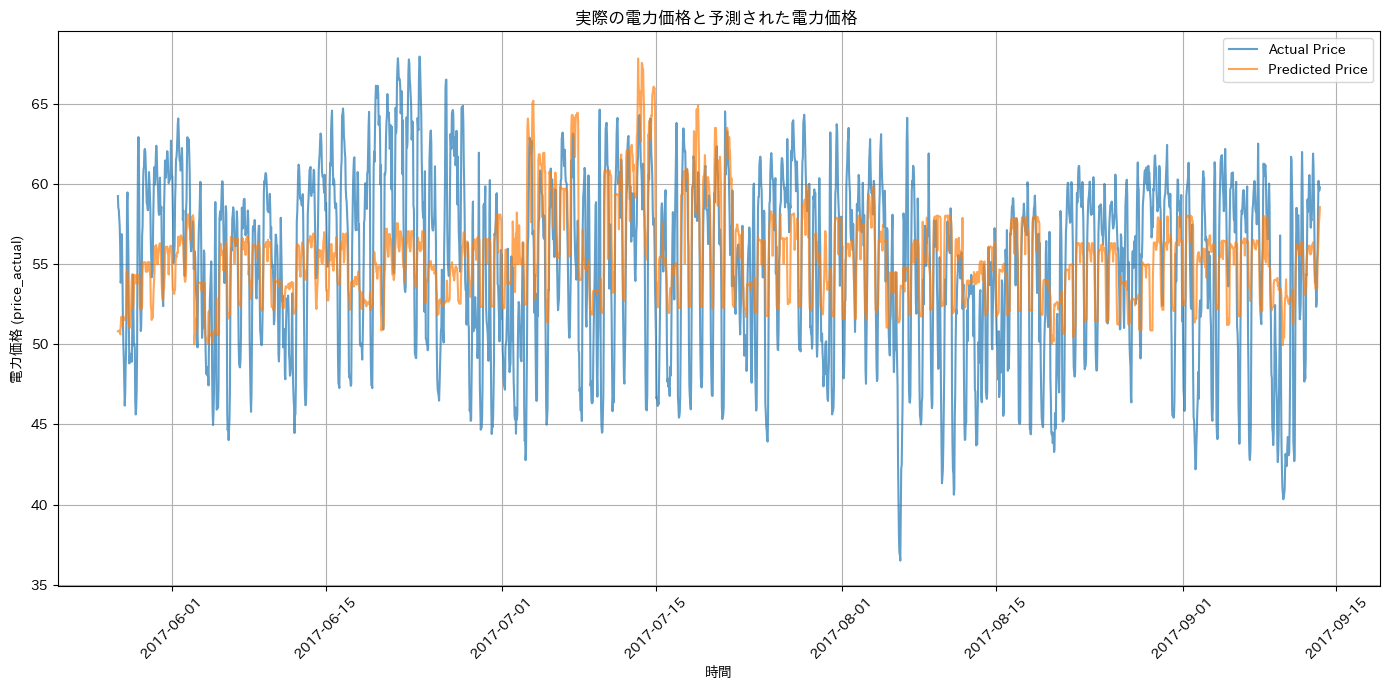


--- Fold 8/8 ---
訓練データ期間: 2015-01-02 00:00:00+01:00 - 2017-09-13 12:00:00+02:00 (サイズ: 23652)
検証データ期間: 2017-09-13 13:00:00+02:00 - 2017-12-31 23:00:00+01:00 (サイズ: 2628)
Fold 8 RMSE: 11.7890


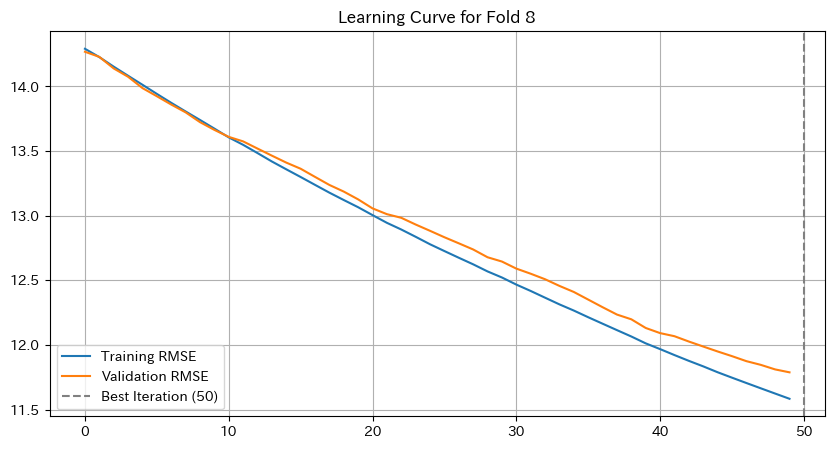

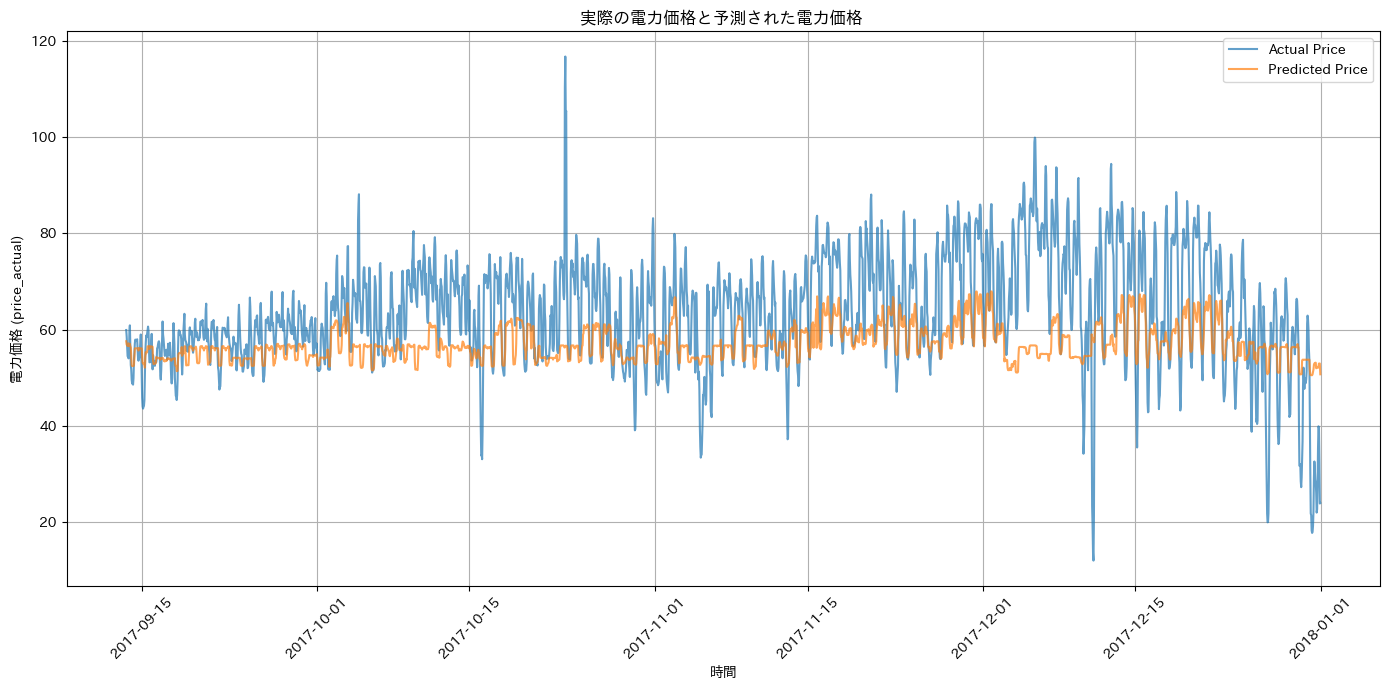


--- ウォークフォワードバリデーションの結果 ---
各FoldのRMSEスコア: [8.259214358137863, 19.61213111799622, 16.128068173402625, 7.300113794352336, 20.484629401893585, 8.497844176105792, 4.6756679430479124, 11.788972059292886]
平均RMSE: 12.0933
RMSEの標準偏差: 5.5783


In [ ]:
# --- ウォークフォワードバリデーションの設定 ---
initial_train_size = int(len(df_model) * 0.2) # 最初の60%を初期訓練データとする
validation_size = int(len(df_model) * 0.1)   # 20%を各検証期間とする

# 繰り返し回数 (分割の数)
n_splits = (len(df_model) - initial_train_size - validation_size) // validation_size + 1 # +1は最初の分割のため


print(f"データ総数: {len(df_model)}")
print(f"初期訓練サイズ: {initial_train_size}")
print(f"検証サイズ (各ステップ): {validation_size}")
print(f"推定分割数: {n_splits}")

all_rmse_scores = []
models = [] # 学習したモデルを保存する場合

for i in range(n_splits):
    print(f"\n--- Fold {i+1}/{n_splits} ---")

    # 訓練データの終了インデックス
    train_end_idx = initial_train_size + i * validation_size

    # 検証データの終了インデックス
    val_end_idx = train_end_idx + validation_size

    # データが利用可能な範囲内に収まっているか確認
    if val_end_idx > len(df):
        # 最後のイテレーションで検証データが指定サイズに満たない場合
        # または、残りのデータが少なすぎる場合にループを終了
        break

    # 訓練データと検証データを時間軸で分割
    # Expanding Window (訓練データが毎回増えていく)
    X_train_fold = X.iloc[:train_end_idx]
    y_train_fold = y.iloc[:train_end_idx]

    # Rolling Window (訓練データの窓が一定長でスライドしていく場合)
    # train_start_idx = train_end_idx - some_fixed_train_window_size
    # X_train_fold = X.iloc[train_start_idx : train_end_idx]
    # y_train_fold = y.iloc[train_start_idx : train_end_idx]


    X_val_fold = X.iloc[train_end_idx : val_end_idx]
    y_val_fold = y.iloc[train_end_idx : val_end_idx]

    print(f"訓練データ期間: {X_train_fold.index.min()} - {X_train_fold.index.max()} (サイズ: {len(X_train_fold)})")
    print(f"検証データ期間: {X_val_fold.index.min()} - {X_val_fold.index.max()} (サイズ: {len(X_val_fold)})")

    # LightGBM Datasetの作成
    lgb_train_fold = lgb.Dataset(X_train_fold, y_train_fold) # categorical_feature=object_cols_train を追加
    lgb_val_fold = lgb.Dataset(X_val_fold, y_val_fold, reference=lgb_train_fold) # categorical_feature=object_cols_train を追加

    # early_stopping コールバック
    early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=False)

    # 評価履歴を格納する辞書 (カスタムコールバック用)
    evaluation_history_fold = {'training': {'rmse': []}, 'valid_0': {'rmse': []}}

    # モデル学習
    fold_model = lgb.train(
        params,
        lgb_train_fold,
        num_boost_round=10000,
        # categorical_feature=object_cols_train, # ここも適切に指定
        valid_sets=[lgb_val_fold, lgb_train_fold],
        callbacks=[
            early_stopping_callback,
            custom_evaluation_callback(evaluation_history_fold)
        ]
    )

    # 検証データでの予測 (最適なイテレーションを使用)
    y_pred_fold = fold_model.predict(X_val_fold, num_iteration=fold_model.best_iteration)

    # 評価 (RMSE)
    rmse_fold = root_mean_squared_error(y_val_fold, y_pred_fold)
    print(f"Fold {i+1} RMSE: {rmse_fold:.4f}")
    all_rmse_scores.append(rmse_fold)
    models.append(fold_model) # モデルを保存したい場合

    # 各Foldの学習曲線を表示したい場合
    plt.figure(figsize=(10, 5))
    plt.plot(evaluation_history_fold['training']['rmse'], label='Training RMSE')
    plt.plot(evaluation_history_fold['valid_0']['rmse'], label='Validation RMSE')
    plt.axvline(x=fold_model.best_iteration, color='gray', linestyle='--', label=f'Best Iteration ({fold_model.best_iteration})')
    plt.title(f'Learning Curve for Fold {i+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 実際の値と予測値の比較をプロット
    plt.figure(figsize=(14, 7))
    plt.plot(y_val_fold.index, y_val_fold, label='Actual Price', alpha=0.7)
    plt.plot(y_val_fold.index, y_pred_fold, label='Predicted Price', alpha=0.7)
    plt.title('実際の電力価格と予測された電力価格 ')
    plt.xlabel('時間')
    plt.ylabel('電力価格 (price_actual)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


# --- 最終結果 ---
print("\n--- ウォークフォワードバリデーションの結果 ---")
print(f"各FoldのRMSEスコア: {all_rmse_scores}")
print(f"平均RMSE: {np.mean(all_rmse_scores):.4f}")
print(f"RMSEの標準偏差: {np.std(all_rmse_scores):.4f}")

In [ ]:
# 最終モデルの再学習
# LightGBMのデータセット形式に変換
lgb_final = lgb.Dataset(X, y)

# early_stopping コールバックをリスト内に定義し、そのインスタンスを保持
early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=False)
# 評価結果を格納するための辞書を準備
evaluation_history = {
    'training': {'rmse': []},
    'valid_0': {'rmse': []} # lgb_val に対応。もしvalid_setsの順序が変わるなら調整
}
# モデル学習 (early stoppingを使用)
final_model = lgb.train(
    params,
    lgb_final,
    num_boost_round=10000, # 試行回数を多めに設定
    ) # 50回改善が見られなければ停止

## テストデータ

In [ ]:
# テストデータの確認
df_test.shape

(8760, 90)

In [ ]:
try:
  df_test = df_test.sort_index() # 時系列順にソート

  # テストデータフレームのインデックス（time）を基準に結合
  # インデックスが完全に一致しない場合、NaNが発生する可能性がある
  test_merged_df = df_test.join(df.drop(columns=['time'], errors='ignore'), how='left', rsuffix=f'_{df_name}')
  print(f"'{df_name}' データフレームをテストデータに結合しました。")
except Exception as e:
  print(f"'{df_name}' データフレームのテストデータへの結合中にエラーが発生しました: {e}")

# 結合後のテストデータフレームのカラム情報と先頭行を確認
print("\n結合後のテストデータフレーム:")
display(test_merged_df.info())
display(test_merged_df.head())
print("\nテストデータフレームのサイズ：", test_merged_df.shape)

'test' データフレームをテストデータに結合しました。

結合後のテストデータフレーム:
<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2018-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Columns: 181 entries, generation_biomass to price_actual
dtypes: float64(121), int64(45), object(15)
memory usage: 12.2+ MB


None

generation_biomass  \
time                                            
2018-01-01 00:00:00+01:00               279.0   
2018-01-01 01:00:00+01:00               282.0   
2018-01-01 02:00:00+01:00               283.0   
2018-01-01 03:00:00+01:00               280.0   
2018-01-01 04:00:00+01:00               286.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2018-01-01 00:00:00+01:00                                   0.0   
2018-01-01 01:00:00+01:00                                   0.0   
2018-01-01 02:00:00+01:00                                   0.0   
2018-01-01 03:00:00+01:00                                   0.0   
2018-01-01 04:00:00+01:00                                   0.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2018-01-01 00:00:00+01:00                 3927.0                        895.0   
2018-01-01 01:00:00+01:00                 3948.0                        878.0   
2018-01-01 02:00:00+01:00                 3791.0                        890.0   
2018-01-01 03:00:00+01:00                 3671.0                        881.0   
2018-01-01 04:00:00+01:00                 3460.0                        861.0   

                           generation_fossil_oil  \
time                                               
2018-01-01 00:00:00+01:00                  189.0   
2018-01-01 01:00:00+01:00                  177.0   
2018-01-01 02:00:00+01:00                  175.0   
2018-01-01 03:00:00+01:00                  175.0   
2018-01-01 04:00:00+01:00                  173.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2018-01-01 00:00:00+01:00                                        230.0   
2018-01-01 01:00:00+01:00                                       1269.0   
2018-01-01 02:00:00+01:00                                       2197.0   
2018-01-01 03:00:00+01:00                                       2965.0   
2018-01-01 04:00:00+01:00                                       2705.0   

                           generation_hydro_run_of_river_and_poundage  \
time                                                                    
2018-01-01 00:00:00+01:00                                      1069.0   
2018-01-01 01:00:00+01:00                                      1058.0   
2018-01-01 02:00:00+01:00                                      1052.0   
2018-01-01 03:00:00+01:00                                      1032.0   
2018-01-01 04:00:00+01:00                                      1001.0   

                           generation_hydro_water_reservoir  \
time                                                          
2018-01-01 00:00:00+01:00                            1893.0   
2018-01-01 01:00:00+01:00                            1024.0   
2018-01-01 02:00:00+01:00                             888.0   
2018-01-01 03:00:00+01:00                             645.0   
2018-01-01 04:00:00+01:00                             661.0   

                           generation_nuclear  generation_other  ...  \
time                                                             ...   
2018-01-01 00:00:00+01:00              7104.0              53.0  ...   
2018-01-01 01:00:00+01:00              7101.0              52.0  ...   
2018-01-01 02:00:00+01:00              7100.0              52.0  ...   
2018-01-01 03:00:00+01:00              7101.0              53.0  ...   
2018-01-01 04:00:00+01:00              7101.0              53.0  ...   

                           seville_wind_deg_test  seville_rain_1h_test  \
time                                                                     
2018-01-01 00:00:00+01:00                    NaN                   NaN   
2018-01-01 01:00:00+01:00                    NaN                   NaN   
2018-0


テストデータフレームのサイズ： (8760, 181)


In [ ]:
# 特徴量 X_test を定義 (学習データと同じカラム構成にする)
# 学習時に使用した特徴量カラムのリストを取得
train_cols = X_train.columns
# 結合済みテストデータをベースにする
X_test_processed = deepcopy(test_merged_df)

# 学習データに存在するカラムで、テストデータに存在しないものを追加
missing_cols_in_test = set(train_cols) - set(X_test_processed.columns)
for c in missing_cols_in_test:
    X_test_processed[c] = np.nan # または適切なデフォルト値 (0など)

# カラムの順序を学習データと同じにする (モデルに投入する際に重要)
X_test_processed = X_test_processed[train_cols]

# 欠損値の確認と処理 (学習データと同じ方法で補完)
print("\nテスト特徴量データの欠損値 (補完前):")
display(X_test_processed.isnull().sum()[X_test_processed.isnull().sum() > 0])


テスト特徴量データの欠損値 (補完前):


generation_biomass                                                              2
generation_fossil_brown_coal/lignite                                            2
generation_fossil_gas                                                           2
generation_fossil_hard_coal                                                     2
generation_fossil_oil                                                           2
generation_hydro_pumped_storage_consumption                                     2
generation_hydro_run_of_river_and_poundage                                      2
generation_hydro_water_reservoir                                                2
generation_nuclear                                                              2
generation_other                                                                2
generation_other_renewable                                                      2
generation_solar                                                                2
generation_waste                                                                2
generation_wind_onshore                                                         2
total_load_actual                                                               3
agged_month_expanding_mean_price_actual                                      8760
agged_day_expanding_mean_price_actual                                        8760
agged_hour_expanding_mean_price_actual                                       8760
agged_dayofweek_expanding_mean_price_actual                                  8760
agged_is_holiday_or_weekend_flag_expanding_mean_price_actual                 8760
agged_is_next_day_holiday_or_weekend_flag_expanding_mean_price_actual        8760
agged_is_previous_day_holiday_or_weekend_flag_expanding_mean_price_actual    8760
agged_consecutive_holiday_or_weekend_expanding_mean_price_actual             8760
dtype: int64

In [ ]:
# 適当に補完
numeric_cols_X_test = X_test_processed.select_dtypes(include=np.number).columns

# それでも補完できていないところは一気に補完 (学習データと同じ方法)
X_test_processed = convert_missing_to_minus_one(X_test_processed)

# 再度欠損値がないか確認
print("\nテスト特徴量データ (欠損値処理後):")
display(X_test_processed.isnull().sum()[X_test_processed.isnull().sum() > 0])
display(X_test_processed.head())
print("\nテストデータフレームのサイズ：", X_test_processed.shape)


テスト特徴量データ (欠損値処理後):


Series([], dtype: int64)

generation_biomass  \
time                                            
2018-01-01 00:00:00+01:00               279.0   
2018-01-01 01:00:00+01:00               282.0   
2018-01-01 02:00:00+01:00               283.0   
2018-01-01 03:00:00+01:00               280.0   
2018-01-01 04:00:00+01:00               286.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2018-01-01 00:00:00+01:00                                   0.0   
2018-01-01 01:00:00+01:00                                   0.0   
2018-01-01 02:00:00+01:00                                   0.0   
2018-01-01 03:00:00+01:00                                   0.0   
2018-01-01 04:00:00+01:00                                   0.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2018-01-01 00:00:00+01:00                 3927.0                        895.0   
2018-01-01 01:00:00+01:00                 3948.0                        878.0   
2018-01-01 02:00:00+01:00                 3791.0                        890.0   
2018-01-01 03:00:00+01:00                 3671.0                        881.0   
2018-01-01 04:00:00+01:00                 3460.0                        861.0   

                           generation_fossil_oil  \
time                                               
2018-01-01 00:00:00+01:00                  189.0   
2018-01-01 01:00:00+01:00                  177.0   
2018-01-01 02:00:00+01:00                  175.0   
2018-01-01 03:00:00+01:00                  175.0   
2018-01-01 04:00:00+01:00                  173.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2018-01-01 00:00:00+01:00                                        230.0   
2018-01-01 01:00:00+01:00                                       1269.0   
2018-01-01 02:00:00+01:00                                       2197.0   
2018-01-01 03:00:00+01:00                                       2965.0   
2018-01-01 04:00:00+01:00                                       2705.0   

                           generation_hydro_run_of_river_and_poundage  \
time                                                                    
2018-01-01 00:00:00+01:00                                      1069.0   
2018-01-01 01:00:00+01:00                                      1058.0   
2018-01-01 02:00:00+01:00                                      1052.0   
2018-01-01 03:00:00+01:00                                      1032.0   
2018-01-01 04:00:00+01:00                                      1001.0   

                           generation_hydro_water_reservoir  \
time                                                          
2018-01-01 00:00:00+01:00                            1893.0   
2018-01-01 01:00:00+01:00                            1024.0   
2018-01-01 02:00:00+01:00                             888.0   
2018-01-01 03:00:00+01:00                             645.0   
2018-01-01 04:00:00+01:00                             661.0   

                           generation_nuclear  generation_other  ...  \
time                                                             ...   
2018-01-01 00:00:00+01:00              7104.0              53.0  ...   
2018-01-01 01:00:00+01:00              7101.0              52.0  ...   
2018-01-01 02:00:00+01:00              7100.0              52.0  ...   
2018-01-01 03:00:00+01:00              7101.0              53.0  ...   
2018-01-01 04:00:00+01:00              7101.0              53.0  ...   

                           seville_rain_3h  seville_snow_3h  \
time                                                          
2018-01-01 00:00:00+01:00              0.0              0.0   
2018-01-01 01:00:00+01:00              0.0              0.0   
2018-01-01 02:00:00+01:00              0.0        


テストデータフレームのサイズ： (8760, 53)


In [ ]:
# テストデータでの予測
Y_pred_test = model.predict(X_test_processed)

# 予測結果の確認
print("\nテストデータ予測結果 :")
print(Y_pred_test[:10]) # 最初の10個を表示

print("\n提出データフレームのサイズ：", Y_pred_test.shape)
print("\n提出データユニーク：", len(np.unique(Y_pred_test)))
u, counts = np.unique(Y_pred_test, return_counts=True)
print(f'重複値：{u[counts != 1]}, \n出現回数{counts[counts != 1]}')
print("-" * 50)


テストデータ予測結果 :
[52.92612726 52.92612726 52.92612726 52.92612726 52.92612726 52.92612726
 52.92612726 52.92612726 52.92612726 52.92612726]

提出データフレームのサイズ： (8760,)

提出データユニーク： 4
重複値：[52.92612726 53.51904481 53.64671238 54.16770822], 
出現回数[6143   29  819 1769]
--------------------------------------------------


## 提出用データの作成

### 提出先
https://signate.jp/competitions/1634/submissions

In [ ]:
print(df_test.index.nunique())
print(X_test_processed.index.nunique())

8760
8760


In [ ]:
# 提出用データフレームの作成
# インデックスは df_test の time カラムをそのまま使用
# データは LightGBM の予測結果 Y_pred_test_lgb を使用

# 提出用データフレームを格納する辞書を作成
submission_df = pd.DataFrame()

submission_df['time'] = X_test_processed.index

# 予測結果を 'price_actual' カラムとして追加
# Y_pred_test_lgb は numpy 配列なので、そのままカラムに設定できる
submission_df['price_actual'] = Y_pred_test
print("ユニークチェック：\n", submission_df.nunique())

ユニークチェック：
 time            8760
price_actual       4
dtype: int64


In [ ]:
# time カラムをリセットして列に戻す（提出フォーマットに合わせるため）
submission_df.reset_index(drop=True, inplace=True)

# 提出用データフレームの確認
print("\n提出用データフレーム:")
display(submission_df.head())
display(submission_df.info())
print(f"提出用データフレームのサイズ: {submission_df.shape}")

# 提出ファイルの保存 (例: submission.csv)
# index=False でインデックスをファイルに書き込まないようにする
submission_path = os.path.join(dir_path, 'submission.csv')
submission_df.to_csv(submission_path, index=False, header=False)

print(f"\n提出用ファイル '{submission_path}' を作成しました。")

# 作成したファイルの確認
!ls $dir_path
!head $submission_path
print("提出するデータの形状：", submission_df.shape)
print("ユニークチェック：\n", submission_df.nunique())
print("-" * 50)


提出用データフレーム:


time  price_actual
0 2018-01-01 00:00:00+01:00     52.926127
1 2018-01-01 01:00:00+01:00     52.926127
2 2018-01-01 02:00:00+01:00     52.926127
3 2018-01-01 03:00:00+01:00     52.926127
4 2018-01-01 04:00:00+01:00     52.926127

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype                        
---  ------        --------------  -----                        
 0   time          8760 non-null   datetime64[ns, Europe/Berlin]
 1   price_actual  8760 non-null   float64                      
dtypes: datetime64[ns, Europe/Berlin](1), float64(1)
memory usage: 137.0 KB


None

提出用データフレームのサイズ: (8760, 2)

提出用ファイル '/content/drive/MyDrive/Colab_Notebooks/signate_smbc_202506/submission.csv' を作成しました。
 feature_description.csv	       submission_lgbm.csv
 sample_submit.csv		       test.csv
 signate_smbc_202506.ipynb	       train.csv
'signate_smbc_202506.ipynb のコピー'   tutorial.ipynb
 submission.csv
2018-01-01 00:00:00+01:00,52.926127257260866
2018-01-01 01:00:00+01:00,52.926127257260866
2018-01-01 02:00:00+01:00,52.926127257260866
2018-01-01 03:00:00+01:00,52.926127257260866
2018-01-01 04:00:00+01:00,52.926127257260866
2018-01-01 05:00:00+01:00,52.926127257260866
2018-01-01 06:00:00+01:00,52.926127257260866
2018-01-01 07:00:00+01:00,52.926127257260866
2018-01-01 08:00:00+01:00,52.926127257260866
2018-01-01 09:00:00+01:00,52.926127257260866
提出するデータの形状： (8760, 2)
ユニークチェック：
 time            8760
price_actual       4
dtype: int64
--------------------------------------------------


In [ ]:
# prompt: 提出用のcsvファイルと作成したファイルをそれぞれ読み込んで確認

# 作成した提出用ファイルを読み込んで確認
print("\n--- 作成した提出用ファイルの内容確認 ---")
try:
    # ヘッダーなしで読み込む必要がある場合
    submission_check_df = pd.read_csv(submission_path, header=None, names=['time', 'price_actual'])
    print(f"作成した提出用ファイル '{submission_path}' を読み込みました。")
    display(submission_check_df.head())
    display(submission_check_df.info())
except Exception as e:
    print(f"作成した提出用ファイル '{submission_path}' の読み込み中にエラーが発生しました: {e}")

# 提出サイトから提供される提出フォーマットファイルを読み込んで確認 (もしあれば)
# 例: sample_submission.csv というファイル名で提供されている場合
sample_submission_path = os.path.join(dir_path, 'sample_submit.csv') # 適切なファイル名に変更してください
if os.path.exists(sample_submission_path):
    print(f"\n--- 提出フォーマットファイル '{sample_submission_path}' の内容確認 ---")
    try:
        # ヘッダーやカラム名を確認して適切に読み込む
        sample_submission_df = pd.read_csv(sample_submission_path, header=None, names=['time', 'price_actual'])
        print(f"提出フォーマットファイル '{sample_submission_path}' を読み込みました。")
        display(sample_submission_df.head())
        display(sample_submission_df.info())

        # 作成したファイルとフォーマットファイルの形状やカラム名が一致しているか確認
        print("\n--- ファイル形式の比較 ---")
        if 'submission_check_df' in locals() and 'sample_submission_df' in locals():
            print(f"作成したファイル形状: {submission_check_df.shape}")
            print(f"フォーマットファイル形状: {sample_submission_df.shape}")
            print(f"作成したファイルカラム: {submission_check_df.columns.tolist()}")
            print(f"フォーマットファイルカラム: {sample_submission_df.columns.tolist()}")

            if submission_check_df.shape == sample_submission_df.shape:
                print("形状が一致しています。")
            else:
                print("注意: 形状が一致していません。確認してください。")

            if submission_check_df.columns.tolist() == sample_submission_df.columns.tolist():
                 print("カラム名と順序が一致しています。")
            else:
                print("注意: カラム名または順序が一致していません。確認してください。")

        else:
            print("比較に必要なデータフレームが見つかりませんでした。")

    except Exception as e:
        print(f"提出フォーマットファイル '{sample_submission_path}' の読み込み中にエラーが発生しました: {e}")
else:
    print(f"\n提出フォーマットファイル '{sample_submission_path}' が見つかりませんでした。")

print("-" * 50)


--- 作成した提出用ファイルの内容確認 ---
作成した提出用ファイル '/content/drive/MyDrive/Colab_Notebooks/signate_smbc_202506/submission.csv' を読み込みました。


time  price_actual
0  2018-01-01 00:00:00+01:00     52.926127
1  2018-01-01 01:00:00+01:00     52.926127
2  2018-01-01 02:00:00+01:00     52.926127
3  2018-01-01 03:00:00+01:00     52.926127
4  2018-01-01 04:00:00+01:00     52.926127

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          8760 non-null   object 
 1   price_actual  8760 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.0+ KB


None


--- 提出フォーマットファイル '/content/drive/MyDrive/Colab_Notebooks/signate_smbc_202506/sample_submit.csv' の内容確認 ---
提出フォーマットファイル '/content/drive/MyDrive/Colab_Notebooks/signate_smbc_202506/sample_submit.csv' を読み込みました。


time  price_actual
0  2018-01-01 00:00:00+01:00             0
1  2018-01-01 01:00:00+01:00             0
2  2018-01-01 02:00:00+01:00             0
3  2018-01-01 03:00:00+01:00             0
4  2018-01-01 04:00:00+01:00             0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   time          8760 non-null   object
 1   price_actual  8760 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 137.0+ KB


None


--- ファイル形式の比較 ---
作成したファイル形状: (8760, 2)
フォーマットファイル形状: (8760, 2)
作成したファイルカラム: ['time', 'price_actual']
フォーマットファイルカラム: ['time', 'price_actual']
形状が一致しています。
カラム名と順序が一致しています。
--------------------------------------------------


In [ ]:
submission_check_df.nunique()

time            8760
price_actual       4
dtype: int64